In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LassoCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
import re
import warnings
warnings.filterwarnings('ignore')


# Step 1: Data Processing

### 1. Train Price

Step 1: Data Analysis, Cleaning and Preprocessing

【1. Read the data file】
Original data loaded: (103871, 55)

【2. Rename columns to English】

【3. 删除数据泄露特征】
已删除数据泄露特征: developer
已删除数据泄露特征: property_company
已删除数据泄露特征: property_office
删除数据泄露特征后的数据形状: (103871, 52)

【4. Convert basic numeric columns】

【5. Exploratory Data Analysis】
Data Shape: (103871, 52)
Total Samples: 103871
Number of Features: 52

Data Types:
object     37
float64    14
int64       1
Name: count, dtype: int64

Missing Value Analysis:
               Missing Count  Missing Ratio
mortgage              103871     100.000000
villa_type            102428      98.610777
ring_position          75774      72.950102
house_intro            75100      72.301220
heating                72926      70.208239
heating_fee            72488      69.786562
net_area               67887      65.357029
ring                   63452      61.087310
house_age              44510      42.851229
parking_fee            43761      42.130142

Target Va

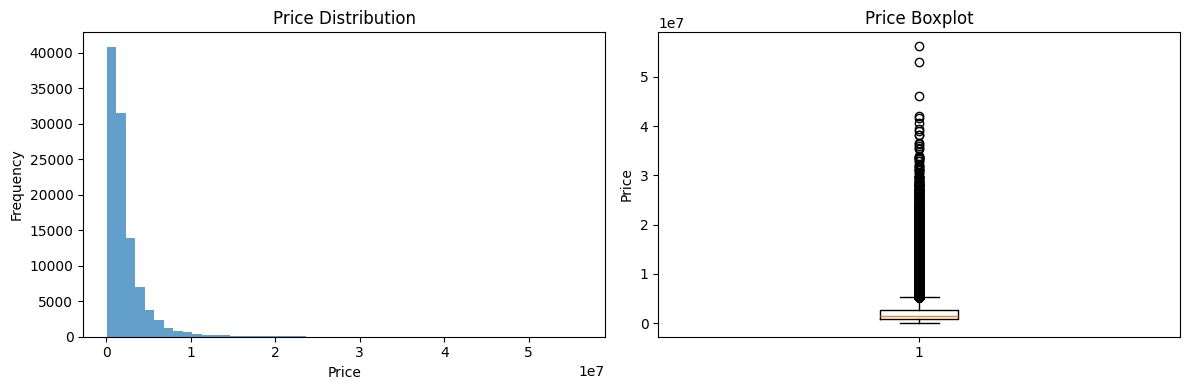


【6. Data Cleaning】

6.1 Drop useless columns:
Dropped completely missing columns: ['mortgage']
Dropped redundant/derived columns: ['district', 'block_comm', 'ring_position', 'property_category', 'property_description']

6.2 Handle Price outliers:
Original Price range: [74553.30, 56226431.30]
Removed data with Price <= 0: 0 rows
IQR outlier bounds: [-1793407.31, 5365255.64]
Detected 7823 outliers (7.53%)
Price range after Winsorize: [254384.58, 12996740.31]

6.3 Drop duplicate data:
Dropped 0 duplicate rows
Data cleaning completed, reduced from 103871 to 103871 rows

【7. Data Preprocessing】

7.1 Handle ring:
Handled ring - 环线位置编码完成

7.2 Handle building_structure:
Handled building_structure - 建筑结构编码完成

7.3 Handle decoration:
Handled decoration - 装修状况编码完成

7.4 Handle elevator:
Handled elevator - 电梯配置编码完成

7.5 Handle villa_type:
Handled villa_type - 别墅类型编码完成

7.6 Handle transaction_date:
Handled transaction_date - 交易日期解析完成

7.7 Handle property_rights:
Handled property_rights - 产权性质编码完成

7

In [2]:
def price_data_analysis_cleaning_preprocessing(file_path, output_path=None):
    """
    房价数据分析、清洗和预处理完整流程
    """
    
    print("=" * 60)
    print("Step 1: Data Analysis, Cleaning and Preprocessing")
    print("=" * 60)
    
    # ==============================================
    # 1. Read the data file
    # ==============================================
    print("\n【1. Read the data file】")
    df = pd.read_csv(file_path)
    print(f"Original data loaded: {df.shape}")
    
    # ==============================================
    # 2. Rename columns to English
    # ==============================================
    print("\n【2. Rename columns to English】")
    df.columns = ['city', 'region', 'block', 'ring', 'Price', 'house_type', 'floor_info', 
                  'building_area', 'net_area', 'orientation', 'building_structure', 
                  'decoration', 'elevator_ratio', 'elevator', 'villa_type', 'transaction_date', 
                  'property_rights', 'last_transaction_date', 'usage', 'house_age', 
                  'property_ownership', 'mortgage', 'house_advantage', 'selling_point', 
                  'house_intro', 'surrounding', 'transportation', 'lon', 'lat', 
                  'year', 'district', 'block_comm', 'ring_position', 'property_category', 
                  'construction_year', 'developer', 'total_households', 'total_buildings', 
                  'property_company', 'green_ratio', 'plot_ratio', 'property_fee', 
                  'building_structure_type', 'property_office', 'property_description', 
                  'water_supply', 'heating', 'electricity', 'gas_fee', 'heating_fee', 
                  'parking_spaces', 'parking_fee', 'coord_x', 'coord_y', 'feedback']
    
    # ==============================================
    # 3. 删除数据泄露特征
    # ==============================================
    print("\n【3. 删除数据泄露特征】")
    leakage_columns = ['developer', 'property_company', 'property_office']
    
    for col in leakage_columns:
        if col in df.columns:
            df = df.drop(columns=[col])
            print(f"已删除数据泄露特征: {col}")
    
    print(f"删除数据泄露特征后的数据形状: {df.shape}")
    
    # ==============================================
    # 4. Convert basic numeric columns
    # ==============================================
    print("\n【4. Convert basic numeric columns】")
    basic_numeric_cols = ['Price', 'lon', 'lat', 'year', 'parking_spaces', 'parking_fee', 'coord_x', 'coord_y']
    
    for col in basic_numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # ==============================================
    # 5. Exploratory Data Analysis
    # ==============================================
    print("\n【5. Exploratory Data Analysis】")
    print(f"Data Shape: {df.shape}")
    print(f"Total Samples: {len(df)}")
    print(f"Number of Features: {df.shape[1]}")
    
    # Data type overview
    print("\nData Types:")
    print(df.dtypes.value_counts())
    
    # Missing value analysis
    print("\nMissing Value Analysis:")
    missing_info = pd.DataFrame({
        'Missing Count': df.isnull().sum(),
        'Missing Ratio': df.isnull().sum() / len(df) * 100
    })
    missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values('Missing Ratio', ascending=False)
    print(missing_info.head(10))
    
    # Target variable (Price) analysis
    print("\nTarget Variable (Price) Analysis:")
    print(df['Price'].describe())
    print(f"Price Skewness: {df['Price'].skew():.3f}")
    print(f"Price Kurtosis: {df['Price'].kurtosis():.3f}")
    
    # Visualize Price distribution
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df['Price'], bins=50, alpha=0.7)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df['Price'])
    plt.title('Price Boxplot')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()
    
    # ==============================================
    # 6. Data Cleaning
    # ==============================================
    print("\n【6. Data Cleaning】")
    
    initial_rows = len(df)
    
    # 6.1 Drop columns with complete missing or redundant data
    print("\n6.1 Drop useless columns:")
    
    # Completely missing columns
    completely_missing = df.columns[df.isnull().all()].tolist()
    if completely_missing:
        df = df.drop(columns=completely_missing)
        print(f"Dropped completely missing columns: {completely_missing}")
    
    # Drop known redundant columns
    redundant_cols = []
    if 'district' in df.columns and 'region' in df.columns:  # Redundant with region
        redundant_cols.append('district')
    if 'block_comm' in df.columns and 'block' in df.columns:  # Redundant with block
        redundant_cols.append('block_comm')
    if 'ring_position' in df.columns and 'ring' in df.columns:  # Redundant with ring
        redundant_cols.append('ring_position')
    
    # Drop derived features (can be derived from other columns)
    derived_cols = ['property_category', 'property_description']  # Derived from usage
    redundant_cols.extend([col for col in derived_cols if col in df.columns])
    
    if redundant_cols:
        df = df.drop(columns=redundant_cols)
        print(f"Dropped redundant/derived columns: {redundant_cols}")
    
    # 6.2 Handle Price outliers
    print("\n6.2 Handle Price outliers:")
    print(f"Original Price range: [{df['Price'].min():.2f}, {df['Price'].max():.2f}]")
    
    # Remove data with Price <= 0
    before_price_clean = len(df)
    df = df[df['Price'] > 0]
    print(f"Removed data with Price <= 0: {before_price_clean - len(df)} rows")
    
    # Use IQR method to identify outliers
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"IQR outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
    print(f"Detected {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")
    
    # Use Winsorize to handle outliers (limit extreme values)
    from scipy.stats import mstats
    df['Price'] = mstats.winsorize(df['Price'], limits=[0.01, 0.01])
    print(f"Price range after Winsorize: [{df['Price'].min():.2f}, {df['Price'].max():.2f}]")
    
    # 6.3 Drop duplicate data
    print("\n6.3 Drop duplicate data:")
    before_dup = len(df)
    df = df.drop_duplicates()
    print(f"Dropped {before_dup - len(df)} duplicate rows")
    
    print(f"Data cleaning completed, reduced from {initial_rows} to {len(df)} rows")
    
    # ==============================================
    # 7. Data Preprocessing
    # ==============================================
    print("\n【7. Data Preprocessing】")
    
    # 7.1 Handle ring (第4列：环线位置，影响交通便利性和价格）
    print("\n7.1 Handle ring:")
    def parse_ring(ring_str):
        """解析环线信息：将环线位置转换为数字编码，数字越小越靠近市中心"""
        if pd.isna(ring_str):
            return np.nan
        
        ring_str = str(ring_str)
        ring_mapping = {
            '二环内': 1, '二至三环': 2, '三至四环': 3, '四至五环': 4, 
            '五至六环': 5, '六环外': 6, '内环内': 2, '内环至中环': 3, 
            '内环至外环': 4, '中环至外环': 5, '外环外': 6
        }
        
        for key, value in ring_mapping.items():
            if key in ring_str:
                return value
        return np.nan
    
    if 'ring' in df.columns:
        df['ring_encoded'] = df['ring'].apply(parse_ring)
        df = df.drop(['ring'], axis=1)
        print("Handled ring - 环线位置编码完成")
    
    # 7.2 Handle building_structure (第11列：建筑结构，影响房屋质量和抗震性）
    print("\n7.2 Handle building_structure:")
    def parse_building_structure(structure_str):
        """解析建筑结构：不同结构类型对应不同的建筑质量等级"""
        if pd.isna(structure_str):
            return np.nan
        
        structure_str = str(structure_str)
        structure_mapping = {
            '钢混结构': 1, '钢结构': 2, '混合结构': 3, '框架结构': 4,
            '未知结构': 5, '砖混结构': 6, '砖木结构': 7
        }
        
        for key, value in structure_mapping.items():
            if key in structure_str:
                return value
        return np.nan
    
    if 'building_structure' in df.columns:
        df['building_structure_encoded'] = df['building_structure'].apply(parse_building_structure)
        df = df.drop(['building_structure'], axis=1)
        print("Handled building_structure - 建筑结构编码完成")
    
    # 7.3 Handle decoration (第12列：装修状况，直接影响房屋价值）
    print("\n7.3 Handle decoration:")
    def parse_decoration(decoration_str):
        """解析装修状况：装修程度越高价值越大"""
        if pd.isna(decoration_str):
            return np.nan
        
        decoration_str = str(decoration_str)
        decoration_mapping = {
            '毛坯': 0, '简装': 1, '精装': 2, '其他': 3
        }
        
        for key, value in decoration_mapping.items():
            if key in decoration_str:
                return value
        return np.nan
    
    if 'decoration' in df.columns:
        df['decoration_encoded'] = df['decoration'].apply(parse_decoration)
        df = df.drop(['decoration'], axis=1)
        print("Handled decoration - 装修状况编码完成")
    
    # 7.4 Handle elevator (第14列：电梯配置，影响居住便利性）
    print("\n7.4 Handle elevator:")
    def parse_elevator(elevator_str):
        """解析电梯配置：有电梯=1，无电梯=0"""
        if pd.isna(elevator_str):
            return np.nan
        
        elevator_str = str(elevator_str)
        if '有' in elevator_str:
            return 1
        elif '无' in elevator_str:
            return 0
        return np.nan
    
    if 'elevator' in df.columns:
        df['elevator_encoded'] = df['elevator'].apply(parse_elevator)
        df = df.drop(['elevator'], axis=1)
        print("Handled elevator - 电梯配置编码完成")
    
    # 7.5 Handle villa_type (第15列：别墅类型，高端房产标识）
    print("\n7.5 Handle villa_type:")
    def parse_villa_type(villa_str):
        """解析别墅类型：不同别墅类型代表不同档次，0表示非别墅"""
        if pd.isna(villa_str):
            return 0  # 不是别墅
        
        villa_str = str(villa_str)
        villa_mapping = {
            '叠拼': 1, '独栋': 2, '联排': 3, '双拼': 4
        }
        
        for key, value in villa_mapping.items():
            if key in villa_str:
                return value
        return 0  # 其他情况也认为不是别墅
    
    if 'villa_type' in df.columns:
        df['villa_type_encoded'] = df['villa_type'].apply(parse_villa_type)
        df = df.drop(['villa_type'], axis=1)
        print("Handled villa_type - 别墅类型编码完成")
    
    # 7.6 Handle transaction_date (第16列：交易日期，转换为年月日数值）
    print("\n7.6 Handle transaction_date:")
    def parse_date_new(date_value):
        """解析交易日期：提取年、月、日信息用于时间序列分析"""
        if pd.isna(date_value):
            return np.nan, np.nan, np.nan
        
        # Convert to string and try different parsing methods
        date_str = str(date_value)
        
        # Try direct pandas datetime parsing first
        try:
            date_obj = pd.to_datetime(date_str)
            return date_obj.year, date_obj.month, date_obj.day
        except:
            pass
        
        # Try regex parsing
        match = re.search(r'(\d{4})[/-](\d{1,2})[/-](\d{1,2})', date_str)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
        
        return np.nan, np.nan, np.nan
    
    if 'transaction_date' in df.columns:
        df[['transaction_year', 'transaction_month', 'transaction_day']] = pd.DataFrame(
            df['transaction_date'].apply(lambda x: pd.Series(parse_date_new(x)))
        )
        df = df.drop(['transaction_date'], axis=1)
        print("Handled transaction_date - 交易日期解析完成")
    
    # 7.7 Handle property_rights (第17列：产权性质，影响房产价值和流通性）
    print("\n7.7 Handle property_rights:")
    def parse_property_rights(rights_str):
        """解析产权性质：不同产权类型影响房产的市场价值"""
        if pd.isna(rights_str):
            return np.nan
        
        rights_str = str(rights_str)
        rights_mapping = {
            '拆迁还建房': 1,     # 价格最低，政策性安置房屋
            '动迁安置房': 2,     # 类似拆迁还建房，价格较低
            '回迁房': 3,         # 安置性质，价格偏低
            '定向安置房': 4,     # 定向安置，价格偏低
            '集资房': 5,         # 单位集资建设，价格相对较低
            '一类经济适用房': 6, # 经济适用房中较低档次
            '经济适用房': 7,     # 政策性住房，价格中等偏下
            '二类经济适用房': 8, # 经济适用房中较高档次
            '限价商品房': 9,     # 限制价格的商品房，价格中等
            '房改房': 10,        # 房改政策房屋，价格中等
            '已购公房': 11,      # 已购买的公房，价格中等偏上
            '售后公房': 12,      # 售出的公房，价格中等偏上
            '央产房': 13,        # 央产房转商品房，价格较高
            '私产': 14,          # 私人产权，价格较高
            '商品房': 15         # 价格最高，完全市场化定价
        }
        
        for key, value in rights_mapping.items():
            if key in rights_str:
                return value
        return np.nan
    
    if 'property_rights' in df.columns:
        df['property_rights_encoded'] = df['property_rights'].apply(parse_property_rights)
        df = df.drop(['property_rights'], axis=1)
        print("Handled property_rights - 产权性质编码完成")
    
    # 7.8 Handle last_transaction_date (第18列：上次交易日期）
    print("\n7.8 Handle last_transaction_date:")
    if 'last_transaction_date' in df.columns:
        df[['last_transaction_year', 'last_transaction_month', 'last_transaction_day']] = pd.DataFrame(
            df['last_transaction_date'].apply(lambda x: pd.Series(parse_date_new(x)))
        )
        df = df.drop(['last_transaction_date'], axis=1)
        print("Handled last_transaction_date - 上次交易日期解析完成")
    
    # 7.9 Handle usage (第19列：房屋用途，不同用途对应不同价格水平）
    print("\n7.9 Handle usage:")
    def parse_usage(usage_str):
        """解析房屋用途：商业用途通常价格更高"""
        if pd.isna(usage_str):
            return np.nan
        
        usage_str = str(usage_str)
        usage_mapping = {
            '车库': 1,           # 价格最低，功能单一的储藏空间
            '商业': 2,           # 一般商业用房，价格较低
            '底商': 3,           # 底层商铺，价格偏低
            '商业办公类': 4,     # 商办混合，价格较低
            '写字楼': 5,         # 纯办公，价格中等偏下
            '商务公寓': 6,       # 商务性质公寓，受政策限制
            '商务型公寓': 7,     # 类似商务公寓
            '酒店式公寓': 8,     # 酒店式管理，价格中等
            '商住两用': 9,       # 商住功能，价格中等
            '老公寓': 10,        # 老式公寓，价格中等
            '公寓': 11,          # 一般公寓，价格中等
            '公寓（住宅）': 12,  # 住宅性质公寓，价格中等偏上
            '公寓/公寓': 13,     # 公寓类型，价格中等偏上
            '住宅式公寓': 14,    # 住宅式管理公寓，价格较高
            '公寓/住宅': 15,     # 公寓住宅混合，价格较高
            '新式里弄': 16,      # 上海特色住宅，价格较高
            '普通住宅': 17,      # 标准住宅，价格较高
            '花园洋房': 18,      # 低密度住宅，价格很高
            '四合院': 19,        # 传统建筑，稀缺性高，价格很高
            '别墅': 20           # 价格最高，独栋住宅
        }
        
        for key, value in usage_mapping.items():
            if key in usage_str:
                return value
        return np.nan
    
    if 'usage' in df.columns:
        df['usage_encoded'] = df['usage'].apply(parse_usage)
        df = df.drop(['usage'], axis=1)
        print("Handled usage - 房屋用途编码完成")
    
    # 7.10 Handle house_age (第20列：房龄状态，影响税费和流通性）
    print("\n7.10 Handle house_age:")
    def parse_house_age_status(age_str):
        """解析房龄状态：满五年和满两年在税费上有重要区别"""
        if pd.isna(age_str):
            return np.nan
        
        age_str = str(age_str)
        if '满两年' in age_str:
            return 2
        elif '满五年' in age_str:
            return 3
        elif '未满两年' in age_str:
            return 1
        return np.nan
    
    if 'house_age' in df.columns:
        df['house_age_status'] = df['house_age'].apply(parse_house_age_status)
        df = df.drop(['house_age'], axis=1)
        print("Handled house_age - 房龄状态编码完成")
    
    # 7.11 Handle property_ownership (第21列：产权共有状况）
    print("\n7.11 Handle property_ownership:")
    def parse_property_ownership(ownership_str):
        """解析产权共有状况：共有产权在交易时程序更复杂"""
        if pd.isna(ownership_str):
            return np.nan
        
        ownership_str = str(ownership_str)
        if '非共有' in ownership_str:
            return 0
        elif '共有' in ownership_str:
            return 1
        return np.nan
    
    if 'property_ownership' in df.columns:
        df['property_ownership_encoded'] = df['property_ownership'].apply(parse_property_ownership)
        df = df.drop(['property_ownership'], axis=1)
        print("Handled property_ownership - 产权共有状况编码完成")
    
    # 7.12 Handle house_advantage (第23列：房屋卖点，提取地铁等关键信息）
    print("\n7.12 Handle house_advantage:")
    def extract_metro_advantage(advantage_str):
        """提取地铁优势：地铁房通常价格更高"""
        if pd.isna(advantage_str):
            return 0
        
        advantage_str = str(advantage_str)
        return 1 if '地铁' in advantage_str else 0
    
    if 'house_advantage' in df.columns:
        df['has_metro'] = df['house_advantage'].apply(extract_metro_advantage)
        df = df.drop(['house_advantage'], axis=1)
        print("Handled house_advantage - 地铁优势提取完成")
    
    # 7.13 Handle construction_year (第35列：建造年份，影响房屋新旧程度）
    print("\n7.13 Handle construction_year:")
    def parse_construction_year(year_str):
        """解析建造年份：提取具体年份数值"""
        if pd.isna(year_str):
            return np.nan
        
        year_str = str(year_str)
        
        # Handle "XXXX年" format
        single_year = re.search(r'(\d{4})年', year_str)
        if single_year:
            return int(single_year.group(1))
        
        # Handle "XXXX-XXXX年" format, take the average
        range_year = re.search(r'(\d{4})-(\d{4})年', year_str)
        if range_year:
            start_year = int(range_year.group(1))
            end_year = int(range_year.group(2))
            return (start_year + end_year) // 2
        
        return np.nan
    
    if 'construction_year' in df.columns:
        df['construction_year_value'] = df['construction_year'].apply(parse_construction_year)
        df = df.drop(['construction_year'], axis=1)
        print("Handled construction_year - 建造年份解析完成")
    
    # 7.14 Handle total_households (第37列：总户数，影响社区规模）
    print("\n7.14 Handle total_households:")
    def extract_households(households_str):
        """提取总户数：社区规模影响居住环境和配套"""
        if pd.isna(households_str):
            return np.nan
        
        households_str = str(households_str)
        match = re.search(r'(\d+)户', households_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_households' in df.columns:
        df['total_households_value'] = df['total_households'].apply(extract_households)
        df = df.drop(['total_households'], axis=1)
        print("Handled total_households - 总户数提取完成")
    
    # 7.15 Handle total_buildings (第38列：总楼栋数）
    print("\n7.15 Handle total_buildings:")
    def extract_buildings(buildings_str):
        """提取总楼栋数：楼栋数量反映社区规模"""
        if pd.isna(buildings_str):
            return np.nan
        
        buildings_str = str(buildings_str)
        match = re.search(r'(\d+)栋', buildings_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_buildings' in df.columns:
        df['total_buildings_value'] = df['total_buildings'].apply(extract_buildings)
        df = df.drop(['total_buildings'], axis=1)
        print("Handled total_buildings - 总楼栋数提取完成")
    
    # 7.16 Handle green_ratio (第40列：绿化率，影响居住环境）
    print("\n7.16 Handle green_ratio:")
    def parse_green_ratio(ratio_str):
        """解析绿化率百分比：高绿化率提升居住品质"""
        if pd.isna(ratio_str):
            return np.nan
        
        ratio_str = str(ratio_str)
        match = re.search(r'(\d+\.?\d*)%', ratio_str)
        return float(match.group(1)) / 100 if match else np.nan
    
    if 'green_ratio' in df.columns:
        df['green_ratio_value'] = df['green_ratio'].apply(parse_green_ratio)
        df = df.drop(['green_ratio'], axis=1)
        print("Handled green_ratio - 绿化率解析完成")
    
    # 7.17 Handle property_fee (第42列：物业费，反映物业服务水平）
    print("\n7.17 Handle property_fee:")
    def parse_property_fee(fee_str):
        """解析物业费：高物业费通常对应更好的服务和环境"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        # Handle range format "X-Y元/月/㎡"
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/月/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        # Handle single value format "X元/月/㎡"
        single_match = re.search(r'(\d+\.?\d*)元/月/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'property_fee' in df.columns:
        df['property_fee_value'] = df['property_fee'].apply(parse_property_fee)
        df = df.drop(['property_fee'], axis=1)
        print("Handled property_fee - 物业费解析完成")
    
    # 7.18 Handle building_structure_type (第43列：建筑结构类型，影响居住体验）
    print("\n7.18 Handle building_structure_type:")
    def parse_building_structure_type(structure_str):
        """解析建筑结构类型关键词：不同结构类型有不同特点"""
        if pd.isna(structure_str):
            return {'板楼': 0, '平房': 0, '塔板结合': 0, '塔楼': 0}
        
        structure_str = str(structure_str)
        return {
            '板楼': 1 if '板楼' in structure_str else 0,
            '平房': 1 if '平房' in structure_str else 0,
            '塔板结合': 1 if '塔板结合' in structure_str else 0,
            '塔楼': 1 if '塔楼' in structure_str else 0
        }
    
    if 'building_structure_type' in df.columns:
        structure_features = pd.DataFrame(
            df['building_structure_type'].apply(lambda x: pd.Series(parse_building_structure_type(x)))
        )
        # Rename columns to avoid conflicts
        structure_features.columns = ['has_banlou', 'has_pingfang', 'has_tabanjiehe', 'has_talou']
        df = pd.concat([df, structure_features], axis=1)
        df = df.drop(['building_structure_type'], axis=1)
        print("Handled building_structure_type - 建筑结构类型编码完成")
    
    # 7.19 Handle water_supply (第46列：供水类型）
    print("\n7.19 Handle water_supply:")
    def parse_water_supply(water_str):
        """解析供水类型：民水(1)、商水(2)、商水/民水(3)，缺失值保持NaN"""
        if pd.isna(water_str):
            return np.nan
        
        water_str = str(water_str)
        if water_str == '民水':
            return 1
        elif water_str == '商水':
            return 2
        elif water_str == '商水/民水':
            return 3
        return np.nan
    
    if 'water_supply' in df.columns:
        df['water_supply_encoded'] = df['water_supply'].apply(parse_water_supply)
        df = df.drop(['water_supply'], axis=1)
        print("Handled water_supply - 供水类型编码完成（1=民水, 2=商水, 3=商水/民水）")
    
    # 7.20 Handle heating (第47列：供暖类型）
    print("\n7.20 Handle heating:")
    def parse_heating(heating_str):
        """解析供暖类型：按指定编码规则1-6"""
        if pd.isna(heating_str):
            return np.nan
        
        heating_str = str(heating_str)
        heating_mapping = { 
            '无供暖': 0,
            '自采暖/无供暖': 1,
            '自采暖': 2,
            '集中供暖': 3,
            '集中供暖/自采暖/无供暖': 4,
            '集中供暖/自采暖': 5
        }
        
        return heating_mapping.get(heating_str, np.nan)
    
    if 'heating' in df.columns:
        df['heating_encoded'] = df['heating'].apply(parse_heating)
        df = df.drop(['heating'], axis=1)
        print("Handled heating - 供暖类型编码完成（1=集中供暖, 2=集中供暖/自采暖, 3=集中供暖/自采暖/无供暖, 4=无供暖, 5=自采暖, 6=自采暖/无供暖）")
    
    # 7.21 Handle electricity (第48列：用电类型）
    print("\n7.21 Handle electricity:")
    def parse_electricity(electricity_str):
        """解析用电类型：民电(1)、商电(2)、商电/民电(3)，缺失值保持NaN"""
        if pd.isna(electricity_str):
            return np.nan
        
        electricity_str = str(electricity_str)
        if electricity_str == '民电':
            return 1
        elif electricity_str == '商电':
            return 2
        elif electricity_str == '商电/民电':
            return 3
        return np.nan
    
    if 'electricity' in df.columns:
        df['electricity_encoded'] = df['electricity'].apply(parse_electricity)
        df = df.drop(['electricity'], axis=1)
        print("Handled electricity - 用电类型编码完成（1=民电, 2=商电, 3=商电/民电）")
    
    # 7.22 Handle gas_fee (第49列：燃气费用）
    print("\n7.22 Handle gas_fee:")
    def parse_gas_fee(fee_str):
        """解析燃气费用：提取数值，范围值取平均"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        # Handle range format "X-Y元/m³"
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/m³', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        # Handle single value format "X元/m³"
        single_match = re.search(r'(\d+\.?\d*)元/m³', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'gas_fee' in df.columns:
        df['gas_fee_value'] = df['gas_fee'].apply(parse_gas_fee)
        df = df.drop(['gas_fee'], axis=1)
        print("Handled gas_fee - 燃气费用解析完成")
    
    # 7.23 Handle heating_fee (第50列：供暖费用）
    print("\n7.23 Handle heating_fee:")
    def parse_heating_fee(fee_str):
        """解析供暖费用：提取数值，范围值取平均"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        # Handle range format "X-Y元/㎡"
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        # Handle single value format "X元/㎡"
        single_match = re.search(r'(\d+\.?\d*)元/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'heating_fee' in df.columns:
        df['heating_fee_value'] = df['heating_fee'].apply(parse_heating_fee)
        df = df.drop(['heating_fee'], axis=1)
        print("Handled heating_fee - 供暖费用解析完成")
    
    # 继续处理其他现有功能...
    
    # 7.24 Handle area features
    print("\n7.24 Handle area features:")
    def extract_area(area_str):
        """提取面积数值：从面积字符串中提取数字"""
        if pd.isna(area_str):
            return np.nan
        match = re.search(r'(\d+\.?\d*)', str(area_str))
        return float(match.group(1)) if match else np.nan
    
    if 'building_area' in df.columns:
        df['building_area_value'] = df['building_area'].apply(extract_area)
        df = df.drop(['building_area'], axis=1)
        print("Handled building area - 建筑面积提取完成")
    
    if 'net_area' in df.columns:
        df['net_area_value'] = df['net_area'].apply(extract_area)
        df = df.drop(['net_area'], axis=1)
        print("Handled net area - 使用面积提取完成")
    
    # 7.25 Handle house type features
    print("\n7.25 Handle house type features:")
    def parse_house_type(house_type):
        """解析户型信息：提取室、厅、厨、卫数量"""
        if pd.isna(house_type):
            return np.nan, np.nan, np.nan, np.nan
        
        house_type = str(house_type)
        
        # Handle "X室X厅X厨X卫" format
        if '室' in house_type:
            rooms = re.search(r'(\d+)室', house_type)
            halls = re.search(r'(\d+)厅', house_type)
            kitchens = re.search(r'(\d+)厨', house_type)
            bathrooms = re.search(r'(\d+)卫', house_type)
            
            return (
                int(rooms.group(1)) if rooms else 0,
                int(halls.group(1)) if halls else 0,
                int(kitchens.group(1)) if kitchens else 0,
                int(bathrooms.group(1)) if bathrooms else 0
            )
        
        # Handle "X房间X卫" format
        elif '房间' in house_type:
            rooms = re.search(r'(\d+)房间', house_type)
            bathrooms = re.search(r'(\d+)卫', house_type)
            
            return (
                int(rooms.group(1)) if rooms else 0,
                0,  # halls
                0,  # kitchens
                int(bathrooms.group(1)) if bathrooms else 0
            )
        
        return np.nan, np.nan, np.nan, np.nan
    
    if 'house_type' in df.columns:
        df[['room', 'hall', 'kitchen', 'bathroom']] = pd.DataFrame(
            df['house_type'].apply(lambda x: pd.Series(parse_house_type(x)))
        )
        df = df.drop(['house_type'], axis=1)
        print("Handled house type - 户型信息解析完成")
    
    # 7.26 Handle floor information
    print("\n7.26 Handle floor information:")
    def parse_floor_info(floor_str):
        """解析楼层信息：提取楼层类型和总楼层数"""
        if pd.isna(floor_str):
            return np.nan, np.nan
        
        floor_str = str(floor_str)
        
        # Extract total floors
        total_match = re.search(r'共(\d+)层', floor_str)
        total_floors = int(total_match.group(1)) if total_match else np.nan
        
        # Floor type encoding
        floor_type_map = {
            '地下室': -1, '底层': 1, '低楼层': 2, 
            '中楼层': 3, '高楼层': 4, '顶层': 5
        }
        
        floor_type = np.nan
        for key, value in floor_type_map.items():
            if key in floor_str:
                floor_type = value
                break
        
        return floor_type, total_floors
    
    if 'floor_info' in df.columns:
        df[['floor_type', 'total_floors']] = pd.DataFrame(
            df['floor_info'].apply(lambda x: pd.Series(parse_floor_info(x)))
        )
        df = df.drop(['floor_info'], axis=1)
        print("Handled floor information - 楼层信息解析完成")
    
    # 7.27 Handle orientation features
    print("\n7.27 Handle orientation features:")
    def parse_orientation(orientation_str):
        """解析朝向信息：转换为one-hot编码"""
        directions = ['东', '南', '西', '北', '东北', '东南', '西北', '西南']
        direction_map = {'东': 'east', '南': 'south', '西': 'west', '北': 'north', 
                        '东北': 'northeast', '东南': 'southeast', '西北': 'northwest', '西南': 'southwest'}
        result = {}
        
        if pd.isna(orientation_str):
            for direction in direction_map.values():
                result[f'orientation_{direction}'] = 0
        else:
            orientation_str = str(orientation_str)
            for chinese, english in direction_map.items():
                result[f'orientation_{english}'] = 1 if chinese in orientation_str else 0
        
        return result
    
    if 'orientation' in df.columns:
        orientation_features = pd.DataFrame(
            df['orientation'].apply(lambda x: pd.Series(parse_orientation(x)))
        )
        df = pd.concat([df, orientation_features], axis=1)
        df = df.drop(['orientation'], axis=1)
        print("Handled orientation - 朝向信息编码完成")
    
    # 7.28 Handle elevator ratio
    print("\n7.28 Handle elevator ratio:")
    def parse_elevator_ratio(ratio_str):
        """解析梯户比：提取电梯数和户数"""
        if pd.isna(ratio_str):
            return np.nan, np.nan
        
        # Chinese number to numeric conversion
        chinese_to_num = {
            '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
            '十一': 11, '十二': 12, '十三': 13, '十四': 14, '十五': 15, '十六': 16, '十七': 17, '十八': 18, '十九': 19, '二十': 20,
            '二十一': 21, '二十二': 22, '二十三': 23, '二十四': 24, '二十五': 25,
            '二十六': 26, '二十七': 27, '二十八': 28, '二十九': 29, '三十': 30, 
            '三十一': 31, '三十二': 32, '三十三': 33, '三十四': 34, '三十五': 35
        }
        
        ratio_str = str(ratio_str)
        match = re.search(r'(.+)梯(.+)户', ratio_str)
        if match:
            elevator_chinese = match.group(1)
            household_chinese = match.group(2)
            elevators = chinese_to_num.get(elevator_chinese, np.nan)
            households = chinese_to_num.get(household_chinese, np.nan)
            return elevators, households
        
        return np.nan, np.nan
    
    if 'elevator_ratio' in df.columns:
        df[['elevators', 'households']] = pd.DataFrame(
            df['elevator_ratio'].apply(lambda x: pd.Series(parse_elevator_ratio(x)))
        )
        # Calculate elevator-household ratio (households/elevators)
        df['elevator_household_ratio'] = df['households'] / df['elevators']
        df = df.drop(['elevator_ratio'], axis=1)
        print("Handled elevator ratio - 梯户比解析完成")
    
    # 7.29 Extract text feature lengths
    print("\n7.29 Handle text features:")
    text_features = ['selling_point', 'house_intro', 'surrounding', 'transportation', 'feedback']
    
    for feature in text_features:
        if feature in df.columns:
            df[f'{feature}_length'] = df[feature].astype(str).str.len()
            df[f'{feature}_word_count'] = df[feature].astype(str).str.split().str.len()
            df = df.drop([feature], axis=1)
            print(f"Handled {feature} - 文本特征长度提取完成")
    
    # 7.30 Handle missing values
    print("\n7.30 Handle missing values:")
    
    # Handle missing values in numeric features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude target variable
    if 'Price' in numeric_cols:
        numeric_cols.remove('Price')
    
    print(f"Number of numeric features: {len(numeric_cols)}")
    
    # Fill numeric features with median (except villa_type_encoded which should not be filled)
    for col in numeric_cols:
        if col != 'villa_type_encoded' and df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  {col}: Filled with median {median_val:.2f}")
    
    # Handle missing values in categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Number of categorical features: {len(categorical_cols)}")
    
    for col in categorical_cols:
        if df[col].isnull().any():
            # Fill with mode, or 'Unknown' if no mode
            if len(df[col].mode()) > 0:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  {col}: Filled with mode '{mode_val}'")
            else:
                df[col] = df[col].fillna('Unknown')
                print(f"  {col}: Filled with 'Unknown'")
    
    # 7.31 Feature Engineering
    print("\n7.31 Feature Engineering:")
    
    # House age feature
    if 'construction_year_value' in df.columns:
        df['calculated_house_age'] = 2024 - df['construction_year_value']
        print("Created calculated house age feature")
    
    # Area-related features
    if 'net_area_value' in df.columns and 'building_area_value' in df.columns:
        df['net_usage_ratio'] = df['net_area_value'] / df['building_area_value']
        df['net_usage_ratio'] = df['net_usage_ratio'].fillna(0)  # Handle divide-by-zero
        print("Created net usage ratio feature")
    
    # House type features
    if all(col in df.columns for col in ['room', 'hall', 'kitchen', 'bathroom']):
        df['total_rooms'] = df['room'] + df['hall']
        df['bathroom_room_ratio'] = df['bathroom'] / df['room']
        df['bathroom_room_ratio'] = df['bathroom_room_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        print("Created house type-related features")
    
    # Floor features
    if 'floor_type' in df.columns and 'total_floors' in df.columns:
        df['floor_ratio'] = df['floor_type'] / df['total_floors']
        df['floor_ratio'] = df['floor_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        print("Created floor ratio feature")
    
    # Geographical feature - Distance to city center
    if 'lat' in df.columns and 'lon' in df.columns:
        # Beijing city center (Tiananmen Square)
        center_lat, center_lon = 39.9042, 116.4074
        df['distance_to_center'] = np.sqrt((df['lat'] - center_lat)**2 + (df['lon'] - center_lon)**2)
        print("Created distance to city center feature")
    
    # Time feature
    if all(col in df.columns for col in ['transaction_year', 'transaction_month', 'transaction_day']):
        # Create complete transaction date feature
        try:
            df['transaction_date_complete'] = pd.to_datetime(df[['transaction_year', 'transaction_month', 'transaction_day']], errors='coerce')
            reference_date = pd.Timestamp('2024-10-26')
            df['days_to_today'] = (reference_date - df['transaction_date_complete']).dt.days
            df = df.drop(['transaction_date_complete'], axis=1)
            print("Created days to today feature")
        except:
            print("Failed to create transaction date feature")
    
    # 7.32 Final data quality check
    print("\n7.32 Final data quality check:")
    print(f"Final data shape: {df.shape}")
    print(f"Remaining missing values: {df.isnull().sum().sum()}")
    
    # Check for any infinite values
    inf_cols = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
    if inf_cols:
        print(f"Columns with infinite values: {inf_cols}")
        for col in inf_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].median())
        print("Handled infinite values")
    
    # ==============================================
    # 8. Save processed data
    # ==============================================
    print("\n【8. Save processed data】")
    
    if output_path is None:
        # Generate output filename based on input filename
        base_name = file_path.replace('.csv', '')
        output_path = f"{base_name}_processed.csv"
    
    # Save the processed data
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Processed data saved to: {output_path}")
    print(f"Saved data shape: {df.shape}")
    
    # Display first few rows of processed data
    print("\nFirst 5 rows of processed data:")
    print(df.head())
    
    # Display column information
    print("\nColumn information:")
    print(f"Total columns: {len(df.columns)}")
    print("Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    print("\nData Analysis, Cleaning and Preprocessing Completed!")
    print("=" * 60)
    
    print("=" * 60)
    print("Step 2: 数据集分割")
    print("=" * 60)
    
    # 分离特征和目标变量
    X = df.drop('Price', axis=1)
    y = df['Price']
    
    print(f"特征矩阵 X 形状: {X.shape}")
    print(f"目标变量 y 形状: {y.shape}")
    
    # 数据分割：80%训练集，20%测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=111
    )
    
    print(f"\n数据分割结果:")
    print(f"训练集 X_train 形状: {X_train.shape}")
    print(f"训练集 y_train 形状: {y_train.shape}")
    print(f"测试集 X_test 形状: {X_test.shape}")
    print(f"测试集 y_test 形状: {y_test.shape}")
    
    # 验证分割比例
    train_ratio = len(X_train) / len(X)
    test_ratio = len(X_test) / len(X)
    print(f"\n分割比例验证:")
    print(f"训练集比例: {train_ratio:.1%}")
    print(f"测试集比例: {test_ratio:.1%}")
    
    print("\n=== 数据处理workflow前2步完成 ===")
    print("✅ (1) 数据分析、清洗和预处理（包含删除数据泄露特征）")
    print("✅ (2) 数据集分割（80%训练，20%测试）")
    
    # 返回分割后的数据集
    return X_train, X_test, y_train, y_test, df  # 返回所有需要的数据

# Process the data and get train/test splits
price_X_train, price_X_test, price_y_train, price_y_test, price_df_processed = price_data_analysis_cleaning_preprocessing('ruc_Class25Q2_train_price.csv')


### 2. Test Price

In [3]:
def price_validation_data_preprocessing(file_path, output_path=None):
    """
    房价验证集数据预处理完整流程（不包含数据分割）
    """
    
    print("=" * 60)
    print("验证集数据预处理")
    print("=" * 60)
    
    # ==============================================
    # 1. Read the validation data file
    # ==============================================
    print("\n【1. Read the validation data file】")
    df = pd.read_csv(file_path)
    print(f"Original validation data loaded: {df.shape}")
    
    # 保存ID列用于最终输出
    validation_ids = df['ID'].copy()
    print(f"保存验证集ID: {len(validation_ids)} 个样本")
    
    # ==============================================
    # 2. Rename columns to English (保留ID列)
    # ==============================================
    print("\n【2. Rename columns to English】")
    df.columns = ['ID', 'city', 'region', 'block', 'ring', 'house_type', 'floor_info', 
                  'building_area', 'net_area', 'orientation', 'building_structure', 
                  'decoration', 'elevator_ratio', 'elevator', 'villa_type', 'transaction_date', 
                  'property_rights', 'last_transaction_date', 'usage', 'house_age', 
                  'property_ownership', 'mortgage', 'house_advantage', 'selling_point', 
                  'house_intro', 'surrounding', 'transportation', 'lon', 'lat', 
                  'year', 'district', 'block_comm', 'ring_position', 'property_category', 
                  'construction_year', 'developer', 'total_households', 'total_buildings', 
                  'property_company', 'green_ratio', 'plot_ratio', 'property_fee', 
                  'building_structure_type', 'property_office', 'property_description', 
                  'water_supply', 'heating', 'electricity', 'gas_fee', 'heating_fee', 
                  'parking_spaces', 'parking_fee', 'coord_x', 'coord_y', 'feedback']
    
    # ==============================================
    # 3. 删除数据泄露特征（第36、39、44列）- 保留ID
    # ==============================================
    print("\n【3. 删除数据泄露特征】")
    leakage_columns = ['developer', 'property_company', 'property_office']
    
    for col in leakage_columns:
        if col in df.columns:
            df = df.drop(columns=[col])
            print(f"已删除数据泄露特征: {col}")
    
    print(f"删除数据泄露特征后的数据形状: {df.shape}")
    
    # ==============================================
    # 4. Convert basic numeric columns (不包含Price)
    # ==============================================
    print("\n【4. Convert basic numeric columns】")
    basic_numeric_cols = ['lon', 'lat', 'year', 'parking_spaces', 'parking_fee', 'coord_x', 'coord_y']
    
    for col in basic_numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # ==============================================
    # 5. Exploratory Data Analysis
    # ==============================================
    print("\n【5. Exploratory Data Analysis】")
    print(f"Data Shape: {df.shape}")
    print(f"Total Samples: {len(df)}")
    print(f"Number of Features: {df.shape[1]}")
    
    # Data type overview
    print("\nData Types:")
    print(df.dtypes.value_counts())
    
    # Missing value analysis
    print("\nMissing Value Analysis:")
    missing_info = pd.DataFrame({
        'Missing Count': df.isnull().sum(),
        'Missing Ratio': df.isnull().sum() / len(df) * 100
    })
    missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values('Missing Ratio', ascending=False)
    print(missing_info.head(10))
    
    # ==============================================
    # 6. Data Cleaning (不包含Price异常值处理)
    # ==============================================
    print("\n【6. Data Cleaning】")
    
    initial_rows = len(df)
    
    # 6.1 Drop columns with complete missing or redundant data
    print("\n6.1 Drop useless columns:")
    
    # Completely missing columns
    completely_missing = df.columns[df.isnull().all()].tolist()
    if completely_missing:
        df = df.drop(columns=completely_missing)
        print(f"Dropped completely missing columns: {completely_missing}")
    
    # Drop known redundant columns
    redundant_cols = []
    if 'district' in df.columns and 'region' in df.columns:  # Redundant with region
        redundant_cols.append('district')
    if 'block_comm' in df.columns and 'block' in df.columns:  # Redundant with block
        redundant_cols.append('block_comm')
    if 'ring_position' in df.columns and 'ring' in df.columns:  # Redundant with ring
        redundant_cols.append('ring_position')
    
    # Drop derived features (can be derived from other columns)
    derived_cols = ['property_category', 'property_description']  # Derived from usage
    redundant_cols.extend([col for col in derived_cols if col in df.columns])
    
    if redundant_cols:
        df = df.drop(columns=redundant_cols)
        print(f"Dropped redundant/derived columns: {redundant_cols}")
    
    # 6.2 Drop duplicate data (基于除ID外的所有列)
    print("\n6.2 Drop duplicate data:")
    before_dup = len(df)
    # 基于除ID外的所有列检查重复
    df = df.drop_duplicates(subset=[col for col in df.columns if col != 'ID'])
    print(f"Dropped {before_dup - len(df)} duplicate rows")
    
    print(f"Data cleaning completed, processed {len(df)} rows")
    
    # ==============================================
    # 7. Data Preprocessing (与训练集完全相同)
    # ==============================================
    print("\n【7. Data Preprocessing】")
    
    # 7.1 Handle ring (第4列：环线位置，影响交通便利性和价格）
    print("\n7.1 Handle ring:")
    def parse_ring(ring_str):
        """解析环线信息：将环线位置转换为数字编码，数字越小越靠近市中心"""
        if pd.isna(ring_str):
            return np.nan
        
        ring_str = str(ring_str)
        ring_mapping = {
            '二环内': 1, '二至三环': 2, '三至四环': 3, '四至五环': 4, 
            '五至六环': 5, '六环外': 6, '内环内': 2, '内环至中环': 3, 
            '内环至外环': 4, '中环至外环': 5, '外环外': 6
        }
        
        for key, value in ring_mapping.items():
            if key in ring_str:
                return value
        return np.nan
    
    if 'ring' in df.columns:
        df['ring_encoded'] = df['ring'].apply(parse_ring)
        df = df.drop(['ring'], axis=1)
        print("Handled ring - 环线位置编码完成")
    
    # 7.2 Handle building_structure (第11列：建筑结构，影响房屋质量和抗震性）
    print("\n7.2 Handle building_structure:")
    def parse_building_structure(structure_str):
        """解析建筑结构：不同结构类型对应不同的建筑质量等级"""
        if pd.isna(structure_str):
            return np.nan
        
        structure_str = str(structure_str)
        structure_mapping = {
            '钢混结构': 1, '钢结构': 2, '混合结构': 3, '框架结构': 4,
            '未知结构': 5, '砖混结构': 6, '砖木结构': 7
        }
        
        for key, value in structure_mapping.items():
            if key in structure_str:
                return value
        return np.nan
    
    if 'building_structure' in df.columns:
        df['building_structure_encoded'] = df['building_structure'].apply(parse_building_structure)
        df = df.drop(['building_structure'], axis=1)
        print("Handled building_structure - 建筑结构编码完成")
    
    # 7.3 Handle decoration (第12列：装修状况，直接影响房屋价值）
    print("\n7.3 Handle decoration:")
    def parse_decoration(decoration_str):
        """解析装修状况：装修程度越高价值越大"""
        if pd.isna(decoration_str):
            return np.nan
        
        decoration_str = str(decoration_str)
        decoration_mapping = {
            '毛坯': 0, '简装': 1, '精装': 2, '其他': 3
        }
        
        for key, value in decoration_mapping.items():
            if key in decoration_str:
                return value
        return np.nan
    
    if 'decoration' in df.columns:
        df['decoration_encoded'] = df['decoration'].apply(parse_decoration)
        df = df.drop(['decoration'], axis=1)
        print("Handled decoration - 装修状况编码完成")
    
    # 7.4 Handle elevator (第14列：电梯配置，影响居住便利性）
    print("\n7.4 Handle elevator:")
    def parse_elevator(elevator_str):
        """解析电梯配置：有电梯=1，无电梯=0"""
        if pd.isna(elevator_str):
            return np.nan
        
        elevator_str = str(elevator_str)
        if '有' in elevator_str:
            return 1
        elif '无' in elevator_str:
            return 0
        return np.nan
    
    if 'elevator' in df.columns:
        df['elevator_encoded'] = df['elevator'].apply(parse_elevator)
        df = df.drop(['elevator'], axis=1)
        print("Handled elevator - 电梯配置编码完成")
    
    # 7.5 Handle villa_type (第15列：别墅类型，高端房产标识）
    print("\n7.5 Handle villa_type:")
    def parse_villa_type(villa_str):
        """解析别墅类型：不同别墅类型代表不同档次，0表示非别墅"""
        if pd.isna(villa_str):
            return 0  # 不是别墅
        
        villa_str = str(villa_str)
        villa_mapping = {
            '叠拼': 1, '独栋': 2, '联排': 3, '双拼': 4
        }
        
        for key, value in villa_mapping.items():
            if key in villa_str:
                return value
        return 0  # 其他情况也认为不是别墅
    
    if 'villa_type' in df.columns:
        df['villa_type_encoded'] = df['villa_type'].apply(parse_villa_type)
        df = df.drop(['villa_type'], axis=1)
        print("Handled villa_type - 别墅类型编码完成")
    
    # 7.6 Handle transaction_date (第16列：交易日期，转换为年月日数值）
    print("\n7.6 Handle transaction_date:")
    def parse_date_new(date_value):
        """解析交易日期：提取年、月、日信息用于时间序列分析"""
        if pd.isna(date_value):
            return np.nan, np.nan, np.nan
        
        # Convert to string and try different parsing methods
        date_str = str(date_value)
        
        # Try direct pandas datetime parsing first
        try:
            date_obj = pd.to_datetime(date_str)
            return date_obj.year, date_obj.month, date_obj.day
        except:
            pass
        
        # Try regex parsing
        match = re.search(r'(\d{4})[/-](\d{1,2})[/-](\d{1,2})', date_str)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
        
        return np.nan, np.nan, np.nan
    
    if 'transaction_date' in df.columns:
        df[['transaction_year', 'transaction_month', 'transaction_day']] = pd.DataFrame(
            df['transaction_date'].apply(lambda x: pd.Series(parse_date_new(x)))
        )
        df = df.drop(['transaction_date'], axis=1)
        print("Handled transaction_date - 交易日期解析完成")
    
    # 7.7 Handle property_rights (第17列：产权性质，影响房产价值和流通性）
    print("\n7.7 Handle property_rights:")
    def parse_property_rights(rights_str):
        """解析产权性质：不同产权类型影响房产的市场价值"""
        if pd.isna(rights_str):
            return np.nan
        
        rights_str = str(rights_str)
        rights_mapping = {
            '拆迁还建房': 1,     # 价格最低，政策性安置房屋
            '动迁安置房': 2,     # 类似拆迁还建房，价格较低
            '回迁房': 3,         # 安置性质，价格偏低
            '定向安置房': 4,     # 定向安置，价格偏低
            '集资房': 5,         # 单位集资建设，价格相对较低
            '一类经济适用房': 6, # 经济适用房中较低档次
            '经济适用房': 7,     # 政策性住房，价格中等偏下
            '二类经济适用房': 8, # 经济适用房中较高档次
            '限价商品房': 9,     # 限制价格的商品房，价格中等
            '房改房': 10,        # 房改政策房屋，价格中等
            '已购公房': 11,      # 已购买的公房，价格中等偏上
            '售后公房': 12,      # 售出的公房，价格中等偏上
            '央产房': 13,        # 央产房转商品房，价格较高
            '私产': 14,          # 私人产权，价格较高
            '商品房': 15         # 价格最高，完全市场化定价
        }
        
        for key, value in rights_mapping.items():
            if key in rights_str:
                return value
        return np.nan
    
    if 'property_rights' in df.columns:
        df['property_rights_encoded'] = df['property_rights'].apply(parse_property_rights)
        df = df.drop(['property_rights'], axis=1)
        print("Handled property_rights - 产权性质编码完成")
    
    # 7.8 Handle last_transaction_date (第18列：上次交易日期）
    print("\n7.8 Handle last_transaction_date:")
    if 'last_transaction_date' in df.columns:
        df[['last_transaction_year', 'last_transaction_month', 'last_transaction_day']] = pd.DataFrame(
            df['last_transaction_date'].apply(lambda x: pd.Series(parse_date_new(x)))
        )
        df = df.drop(['last_transaction_date'], axis=1)
        print("Handled last_transaction_date - 上次交易日期解析完成")
    
    # 7.9 Handle usage (第19列：房屋用途，不同用途对应不同价格水平）
    print("\n7.9 Handle usage:")
    def parse_usage(usage_str):
        """解析房屋用途：商业用途通常价格更高"""
        if pd.isna(usage_str):
            return np.nan
        
        usage_str = str(usage_str)
        usage_mapping = {
            '车库': 1,           # 价格最低，功能单一的储藏空间
            '商业': 2,           # 一般商业用房，价格较低
            '底商': 3,           # 底层商铺，价格偏低
            '商业办公类': 4,     # 商办混合，价格较低
            '写字楼': 5,         # 纯办公，价格中等偏下
            '商务公寓': 6,       # 商务性质公寓，受政策限制
            '商务型公寓': 7,     # 类似商务公寓
            '酒店式公寓': 8,     # 酒店式管理，价格中等
            '商住两用': 9,       # 商住功能，价格中等
            '老公寓': 10,        # 老式公寓，价格中等
            '公寓': 11,          # 一般公寓，价格中等
            '公寓（住宅）': 12,  # 住宅性质公寓，价格中等偏上
            '公寓/公寓': 13,     # 公寓类型，价格中等偏上
            '住宅式公寓': 14,    # 住宅式管理公寓，价格较高
            '公寓/住宅': 15,     # 公寓住宅混合，价格较高
            '新式里弄': 16,      # 上海特色住宅，价格较高
            '普通住宅': 17,      # 标准住宅，价格较高
            '花园洋房': 18,      # 低密度住宅，价格很高
            '四合院': 19,        # 传统建筑，稀缺性高，价格很高
            '别墅': 20           # 价格最高，独栋住宅
        }
        
        for key, value in usage_mapping.items():
            if key in usage_str:
                return value
        return np.nan
    
    if 'usage' in df.columns:
        df['usage_encoded'] = df['usage'].apply(parse_usage)
        df = df.drop(['usage'], axis=1)
        print("Handled usage - 房屋用途编码完成")
    
    # 7.10 Handle house_age (第20列：房龄状态，影响税费和流通性）
    print("\n7.10 Handle house_age:")
    def parse_house_age_status(age_str):
        """解析房龄状态：满五年和满两年在税费上有重要区别"""
        if pd.isna(age_str):
            return np.nan
        
        age_str = str(age_str)
        if '满两年' in age_str:
            return 2
        elif '满五年' in age_str:
            return 3
        elif '未满两年' in age_str:
            return 1
        return np.nan
    
    if 'house_age' in df.columns:
        df['house_age_status'] = df['house_age'].apply(parse_house_age_status)
        df = df.drop(['house_age'], axis=1)
        print("Handled house_age - 房龄状态编码完成")
    
    # 7.11 Handle property_ownership (第21列：产权共有状况）
    print("\n7.11 Handle property_ownership:")
    def parse_property_ownership(ownership_str):
        """解析产权共有状况：共有产权在交易时程序更复杂"""
        if pd.isna(ownership_str):
            return np.nan
        
        ownership_str = str(ownership_str)
        if '非共有' in ownership_str:
            return 0
        elif '共有' in ownership_str:
            return 1
        return np.nan
    
    if 'property_ownership' in df.columns:
        df['property_ownership_encoded'] = df['property_ownership'].apply(parse_property_ownership)
        df = df.drop(['property_ownership'], axis=1)
        print("Handled property_ownership - 产权共有状况编码完成")
    
    # 7.12 Handle house_advantage (第23列：房屋卖点，提取地铁等关键信息）
    print("\n7.12 Handle house_advantage:")
    def extract_metro_advantage(advantage_str):
        """提取地铁优势：地铁房通常价格更高"""
        if pd.isna(advantage_str):
            return 0
        
        advantage_str = str(advantage_str)
        return 1 if '地铁' in advantage_str else 0
    
    if 'house_advantage' in df.columns:
        df['has_metro'] = df['house_advantage'].apply(extract_metro_advantage)
        df = df.drop(['house_advantage'], axis=1)
        print("Handled house_advantage - 地铁优势提取完成")
    
    # 7.13 Handle construction_year (第35列：建造年份，影响房屋新旧程度）
    print("\n7.13 Handle construction_year:")
    def parse_construction_year(year_str):
        """解析建造年份：提取具体年份数值"""
        if pd.isna(year_str):
            return np.nan
        
        year_str = str(year_str)
        
        # Handle "XXXX年" format
        single_year = re.search(r'(\d{4})年', year_str)
        if single_year:
            return int(single_year.group(1))
        
        # Handle "XXXX-XXXX年" format, take the average
        range_year = re.search(r'(\d{4})-(\d{4})年', year_str)
        if range_year:
            start_year = int(range_year.group(1))
            end_year = int(range_year.group(2))
            return (start_year + end_year) // 2
        
        return np.nan
    
    if 'construction_year' in df.columns:
        df['construction_year_value'] = df['construction_year'].apply(parse_construction_year)
        df = df.drop(['construction_year'], axis=1)
        print("Handled construction_year - 建造年份解析完成")
    
    # 7.14 Handle total_households (第37列：总户数，影响社区规模）
    print("\n7.14 Handle total_households:")
    def extract_households(households_str):
        """提取总户数：社区规模影响居住环境和配套"""
        if pd.isna(households_str):
            return np.nan
        
        households_str = str(households_str)
        match = re.search(r'(\d+)户', households_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_households' in df.columns:
        df['total_households_value'] = df['total_households'].apply(extract_households)
        df = df.drop(['total_households'], axis=1)
        print("Handled total_households - 总户数提取完成")
    
    # 7.15 Handle total_buildings (第38列：总楼栋数）
    print("\n7.15 Handle total_buildings:")
    def extract_buildings(buildings_str):
        """提取总楼栋数：楼栋数量反映社区规模"""
        if pd.isna(buildings_str):
            return np.nan
        
        buildings_str = str(buildings_str)
        match = re.search(r'(\d+)栋', buildings_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_buildings' in df.columns:
        df['total_buildings_value'] = df['total_buildings'].apply(extract_buildings)
        df = df.drop(['total_buildings'], axis=1)
        print("Handled total_buildings - 总楼栋数提取完成")
    
    # 7.16 Handle green_ratio (第40列：绿化率，影响居住环境）
    print("\n7.16 Handle green_ratio:")
    def parse_green_ratio(ratio_str):
        """解析绿化率百分比：高绿化率提升居住品质"""
        if pd.isna(ratio_str):
            return np.nan
        
        ratio_str = str(ratio_str)
        match = re.search(r'(\d+\.?\d*)%', ratio_str)
        return float(match.group(1)) / 100 if match else np.nan
    
    if 'green_ratio' in df.columns:
        df['green_ratio_value'] = df['green_ratio'].apply(parse_green_ratio)
        df = df.drop(['green_ratio'], axis=1)
        print("Handled green_ratio - 绿化率解析完成")
    
    # 7.17 Handle property_fee (第42列：物业费，反映物业服务水平）
    print("\n7.17 Handle property_fee:")
    def parse_property_fee(fee_str):
        """解析物业费：高物业费通常对应更好的服务和环境"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        # Handle range format "X-Y元/月/㎡"
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/月/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        # Handle single value format "X元/月/㎡"
        single_match = re.search(r'(\d+\.?\d*)元/月/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'property_fee' in df.columns:
        df['property_fee_value'] = df['property_fee'].apply(parse_property_fee)
        df = df.drop(['property_fee'], axis=1)
        print("Handled property_fee - 物业费解析完成")
    
    # 7.18 Handle building_structure_type (第43列：建筑结构类型，影响居住体验）
    print("\n7.18 Handle building_structure_type:")
    def parse_building_structure_type(structure_str):
        """解析建筑结构类型关键词：不同结构类型有不同特点"""
        if pd.isna(structure_str):
            return {'板楼': 0, '平房': 0, '塔板结合': 0, '塔楼': 0}
        
        structure_str = str(structure_str)
        return {
            '板楼': 1 if '板楼' in structure_str else 0,
            '平房': 1 if '平房' in structure_str else 0,
            '塔板结合': 1 if '塔板结合' in structure_str else 0,
            '塔楼': 1 if '塔楼' in structure_str else 0
        }
    
    if 'building_structure_type' in df.columns:
        structure_features = pd.DataFrame(
            df['building_structure_type'].apply(lambda x: pd.Series(parse_building_structure_type(x)))
        )
        # Rename columns to avoid conflicts
        structure_features.columns = ['has_banlou', 'has_pingfang', 'has_tabanjiehe', 'has_talou']
        df = pd.concat([df, structure_features], axis=1)
        df = df.drop(['building_structure_type'], axis=1)
        print("Handled building_structure_type - 建筑结构类型编码完成")
    
    # 7.19 Handle water_supply (第46列：供水类型）
    print("\n7.19 Handle water_supply:")
    def parse_water_supply(water_str):
        """解析供水类型：民水(1)、商水(2)、商水/民水(3)，缺失值保持NaN"""
        if pd.isna(water_str):
            return np.nan
        
        water_str = str(water_str)
        if water_str == '民水':
            return 1
        elif water_str == '商水':
            return 2
        elif water_str == '商水/民水':
            return 3
        return np.nan
    
    if 'water_supply' in df.columns:
        df['water_supply_encoded'] = df['water_supply'].apply(parse_water_supply)
        df = df.drop(['water_supply'], axis=1)
        print("Handled water_supply - 供水类型编码完成（1=民水, 2=商水, 3=商水/民水）")
    
    # 7.20 Handle heating (第47列：供暖类型）
    print("\n7.20 Handle heating:")
    def parse_heating(heating_str):
        """解析供暖类型：按指定编码规则1-6"""
        if pd.isna(heating_str):
            return np.nan
        
        heating_str = str(heating_str)
        heating_mapping = { 
            '无供暖': 0,
            '自采暖/无供暖': 1,
            '自采暖': 2,
            '集中供暖': 3,
            '集中供暖/自采暖/无供暖': 4,
            '集中供暖/自采暖': 5
        }
        
        return heating_mapping.get(heating_str, np.nan)
    
    if 'heating' in df.columns:
        df['heating_encoded'] = df['heating'].apply(parse_heating)
        df = df.drop(['heating'], axis=1)
        print("Handled heating - 供暖类型编码完成（1=集中供暖, 2=集中供暖/自采暖, 3=集中供暖/自采暖/无供暖, 4=无供暖, 5=自采暖, 6=自采暖/无供暖）")
    
    # 7.21 Handle electricity (第48列：用电类型）
    print("\n7.21 Handle electricity:")
    def parse_electricity(electricity_str):
        """解析用电类型：民电(1)、商电(2)、商电/民电(3)，缺失值保持NaN"""
        if pd.isna(electricity_str):
            return np.nan
        
        electricity_str = str(electricity_str)
        if electricity_str == '民电':
            return 1
        elif electricity_str == '商电':
            return 2
        elif electricity_str == '商电/民电':
            return 3
        return np.nan
    
    if 'electricity' in df.columns:
        df['electricity_encoded'] = df['electricity'].apply(parse_electricity)
        df = df.drop(['electricity'], axis=1)
        print("Handled electricity - 用电类型编码完成（1=民电, 2=商电, 3=商电/民电）")
    
    # 7.22 Handle gas_fee (第49列：燃气费用）
    print("\n7.22 Handle gas_fee:")
    def parse_gas_fee(fee_str):
        """解析燃气费用：提取数值，范围值取平均"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        # Handle range format "X-Y元/m³"
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/m³', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        # Handle single value format "X元/m³"
        single_match = re.search(r'(\d+\.?\d*)元/m³', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'gas_fee' in df.columns:
        df['gas_fee_value'] = df['gas_fee'].apply(parse_gas_fee)
        df = df.drop(['gas_fee'], axis=1)
        print("Handled gas_fee - 燃气费用解析完成")
    
    # 7.23 Handle heating_fee (第50列：供暖费用）
    print("\n7.23 Handle heating_fee:")
    def parse_heating_fee(fee_str):
        """解析供暖费用：提取数值，范围值取平均"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        # Handle range format "X-Y元/㎡"
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        # Handle single value format "X元/㎡"
        single_match = re.search(r'(\d+\.?\d*)元/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'heating_fee' in df.columns:
        df['heating_fee_value'] = df['heating_fee'].apply(parse_heating_fee)
        df = df.drop(['heating_fee'], axis=1)
        print("Handled heating_fee - 供暖费用解析完成")
    
    # 继续处理其他现有功能...
    
    # 7.24 Handle area features
    print("\n7.24 Handle area features:")
    def extract_area(area_str):
        """提取面积数值：从面积字符串中提取数字"""
        if pd.isna(area_str):
            return np.nan
        match = re.search(r'(\d+\.?\d*)', str(area_str))
        return float(match.group(1)) if match else np.nan
    
    if 'building_area' in df.columns:
        df['building_area_value'] = df['building_area'].apply(extract_area)
        df = df.drop(['building_area'], axis=1)
        print("Handled building area - 建筑面积提取完成")
    
    if 'net_area' in df.columns:
        df['net_area_value'] = df['net_area'].apply(extract_area)
        df = df.drop(['net_area'], axis=1)
        print("Handled net area - 使用面积提取完成")
    
    # 7.25 Handle house type features
    print("\n7.25 Handle house type features:")
    def parse_house_type(house_type):
        """解析户型信息：提取室、厅、厨、卫数量"""
        if pd.isna(house_type):
            return np.nan, np.nan, np.nan, np.nan
        
        house_type = str(house_type)
        
        # Handle "X室X厅X厨X卫" format
        if '室' in house_type:
            rooms = re.search(r'(\d+)室', house_type)
            halls = re.search(r'(\d+)厅', house_type)
            kitchens = re.search(r'(\d+)厨', house_type)
            bathrooms = re.search(r'(\d+)卫', house_type)
            
            return (
                int(rooms.group(1)) if rooms else 0,
                int(halls.group(1)) if halls else 0,
                int(kitchens.group(1)) if kitchens else 0,
                int(bathrooms.group(1)) if bathrooms else 0
            )
        
        # Handle "X房间X卫" format
        elif '房间' in house_type:
            rooms = re.search(r'(\d+)房间', house_type)
            bathrooms = re.search(r'(\d+)卫', house_type)
            
            return (
                int(rooms.group(1)) if rooms else 0,
                0,  # halls
                0,  # kitchens
                int(bathrooms.group(1)) if bathrooms else 0
            )
        
        return np.nan, np.nan, np.nan, np.nan
    
    if 'house_type' in df.columns:
        df[['room', 'hall', 'kitchen', 'bathroom']] = pd.DataFrame(
            df['house_type'].apply(lambda x: pd.Series(parse_house_type(x)))
        )
        df = df.drop(['house_type'], axis=1)
        print("Handled house type - 户型信息解析完成")
    
    # 7.26 Handle floor information
    print("\n7.26 Handle floor information:")
    def parse_floor_info(floor_str):
        """解析楼层信息：提取楼层类型和总楼层数"""
        if pd.isna(floor_str):
            return np.nan, np.nan
        
        floor_str = str(floor_str)
        
        # Extract total floors
        total_match = re.search(r'共(\d+)层', floor_str)
        total_floors = int(total_match.group(1)) if total_match else np.nan
        
        # Floor type encoding
        floor_type_map = {
            '地下室': -1, '底层': 1, '低楼层': 2, 
            '中楼层': 3, '高楼层': 4, '顶层': 5
        }
        
        floor_type = np.nan
        for key, value in floor_type_map.items():
            if key in floor_str:
                floor_type = value
                break
        
        return floor_type, total_floors
    
    if 'floor_info' in df.columns:
        df[['floor_type', 'total_floors']] = pd.DataFrame(
            df['floor_info'].apply(lambda x: pd.Series(parse_floor_info(x)))
        )
        df = df.drop(['floor_info'], axis=1)
        print("Handled floor information - 楼层信息解析完成")
    
    # 7.27 Handle orientation features
    print("\n7.27 Handle orientation features:")
    def parse_orientation(orientation_str):
        """解析朝向信息：转换为one-hot编码"""
        directions = ['东', '南', '西', '北', '东北', '东南', '西北', '西南']
        direction_map = {'东': 'east', '南': 'south', '西': 'west', '北': 'north', 
                        '东北': 'northeast', '东南': 'southeast', '西北': 'northwest', '西南': 'southwest'}
        result = {}
        
        if pd.isna(orientation_str):
            for direction in direction_map.values():
                result[f'orientation_{direction}'] = 0
        else:
            orientation_str = str(orientation_str)
            for chinese, english in direction_map.items():
                result[f'orientation_{english}'] = 1 if chinese in orientation_str else 0
        
        return result
    
    if 'orientation' in df.columns:
        orientation_features = pd.DataFrame(
            df['orientation'].apply(lambda x: pd.Series(parse_orientation(x)))
        )
        df = pd.concat([df, orientation_features], axis=1)
        df = df.drop(['orientation'], axis=1)
        print("Handled orientation - 朝向信息编码完成")
    
    # 7.28 Handle elevator ratio
    print("\n7.28 Handle elevator ratio:")
    def parse_elevator_ratio(ratio_str):
        """解析梯户比：提取电梯数和户数"""
        if pd.isna(ratio_str):
            return np.nan, np.nan
        
        # Chinese number to numeric conversion
        chinese_to_num = {
            '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9, '十': 10,
            '十一': 11, '十二': 12, '十三': 13, '十四': 14, '十五': 15, '十六': 16, '十七': 17, '十八': 18, '十九': 19, '二十': 20,
            '二十一': 21, '二十二': 22, '二十三': 23, '二十四': 24, '二十五': 25,
            '二十六': 26, '二十七': 27, '二十八': 28, '二十九': 29, '三十': 30, 
            '三十一': 31, '三十二': 32, '三十三': 33, '三十四': 34, '三十五': 35
        }
        
        ratio_str = str(ratio_str)
        match = re.search(r'(.+)梯(.+)户', ratio_str)
        if match:
            elevator_chinese = match.group(1)
            household_chinese = match.group(2)
            elevators = chinese_to_num.get(elevator_chinese, np.nan)
            households = chinese_to_num.get(household_chinese, np.nan)
            return elevators, households
        
        return np.nan, np.nan
    
    if 'elevator_ratio' in df.columns:
        df[['elevators', 'households']] = pd.DataFrame(
            df['elevator_ratio'].apply(lambda x: pd.Series(parse_elevator_ratio(x)))
        )
        # Calculate elevator-household ratio (households/elevators)
        df['elevator_household_ratio'] = df['households'] / df['elevators']
        df = df.drop(['elevator_ratio'], axis=1)
        print("Handled elevator ratio - 梯户比解析完成")
    
    # 7.29 Extract text feature lengths
    print("\n7.29 Handle text features:")
    text_features = ['selling_point', 'house_intro', 'surrounding', 'transportation', 'feedback']
    
    for feature in text_features:
        if feature in df.columns:
            df[f'{feature}_length'] = df[feature].astype(str).str.len()
            df[f'{feature}_word_count'] = df[feature].astype(str).str.split().str.len()
            df = df.drop([feature], axis=1)
            print(f"Handled {feature} - 文本特征长度提取完成")
    
    # 7.30 Handle missing values
    print("\n7.30 Handle missing values:")
    
    # Handle missing values in numeric features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude ID column
    if 'ID' in numeric_cols:
        numeric_cols.remove('ID')
    
    print(f"Number of numeric features: {len(numeric_cols)}")
    
    # Fill numeric features with median (except villa_type_encoded which should not be filled)
    for col in numeric_cols:
        if col != 'villa_type_encoded' and df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  {col}: Filled with median {median_val:.2f}")
    
    # Handle missing values in categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Number of categorical features: {len(categorical_cols)}")
    
    for col in categorical_cols:
        if df[col].isnull().any():
            # Fill with mode, or 'Unknown' if no mode
            if len(df[col].mode()) > 0:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  {col}: Filled with mode '{mode_val}'")
            else:
                df[col] = df[col].fillna('Unknown')
                print(f"  {col}: Filled with 'Unknown'")
    
    # 7.31 Feature Engineering
    print("\n7.31 Feature Engineering:")
    
    # House age feature
    if 'construction_year_value' in df.columns:
        df['calculated_house_age'] = 2024 - df['construction_year_value']
        print("Created calculated house age feature")
    
    # Area-related features
    if 'net_area_value' in df.columns and 'building_area_value' in df.columns:
        df['net_usage_ratio'] = df['net_area_value'] / df['building_area_value']
        df['net_usage_ratio'] = df['net_usage_ratio'].fillna(0)  # Handle divide-by-zero
        print("Created net usage ratio feature")
    
    # House type features
    if all(col in df.columns for col in ['room', 'hall', 'kitchen', 'bathroom']):
        df['total_rooms'] = df['room'] + df['hall']
        df['bathroom_room_ratio'] = df['bathroom'] / df['room']
        df['bathroom_room_ratio'] = df['bathroom_room_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        print("Created house type-related features")
    
    # Floor features
    if 'floor_type' in df.columns and 'total_floors' in df.columns:
        df['floor_ratio'] = df['floor_type'] / df['total_floors']
        df['floor_ratio'] = df['floor_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        print("Created floor ratio feature")
    
    # Geographical feature - Distance to city center
    if 'lat' in df.columns and 'lon' in df.columns:
        # Beijing city center (Tiananmen Square)
        center_lat, center_lon = 39.9042, 116.4074
        df['distance_to_center'] = np.sqrt((df['lat'] - center_lat)**2 + (df['lon'] - center_lon)**2)
        print("Created distance to city center feature")
    
    # Time feature
    if all(col in df.columns for col in ['transaction_year', 'transaction_month', 'transaction_day']):
        # Create complete transaction date feature
        try:
            df['transaction_date_complete'] = pd.to_datetime(df[['transaction_year', 'transaction_month', 'transaction_day']], errors='coerce')
            reference_date = pd.Timestamp('2024-10-26')
            df['days_to_today'] = (reference_date - df['transaction_date_complete']).dt.days
            df = df.drop(['transaction_date_complete'], axis=1)
            print("Created days to today feature")
        except:
            print("Failed to create transaction date feature")
    
    # 7.32 Final data quality check
    print("\n7.32 Final data quality check:")
    print(f"Final data shape: {df.shape}")
    print(f"Remaining missing values: {df.isnull().sum().sum()}")
    
    # Check for any infinite values
    inf_cols = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
    if inf_cols:
        print(f"Columns with infinite values: {inf_cols}")
        for col in inf_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].median())
        print("Handled infinite values")
    
    # ==============================================
    # 8. Save processed validation data
    # ==============================================
    print("\n【8. Save processed validation data】")
    
    if output_path is None:
        # Generate output filename based on input filename
        base_name = file_path.replace('.csv', '')
        output_path = f"{base_name}_processed.csv"
    
    # Save the processed data
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"Processed validation data saved to: {output_path}")
    print(f"Saved data shape: {df.shape}")
    
    # Display first few rows of processed data
    print("\nFirst 5 rows of processed validation data:")
    print(df.head())
    
    # Display column information
    print("\nColumn information:")
    print(f"Total columns: {len(df.columns)}")
    print("Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    print("\n验证集数据预处理完成!")
    print("=" * 60)
    
    # 分离ID和特征
    X_validation = df.drop('ID', axis=1)
    
    print(f"验证集特征矩阵 X_validation 形状: {X_validation.shape}")
    print(f"验证集ID数量: {len(validation_ids)}")
    
    # 返回处理后的验证集特征和ID
    return X_validation, validation_ids, df

# 处理验证集数据
price_X_validation, price_validation_ids, price_df_validation_processed = price_validation_data_preprocessing('ruc_Class25Q2_test_price.csv')


验证集数据预处理

【1. Read the validation data file】
Original validation data loaded: (34017, 55)
保存验证集ID: 34017 个样本

【2. Rename columns to English】

【3. 删除数据泄露特征】
已删除数据泄露特征: developer
已删除数据泄露特征: property_company
已删除数据泄露特征: property_office
删除数据泄露特征后的数据形状: (34017, 52)

【4. Convert basic numeric columns】

【5. Exploratory Data Analysis】
Data Shape: (34017, 52)
Total Samples: 34017
Number of Features: 52

Data Types:
object     37
float64    13
int64       2
Name: count, dtype: int64

Missing Value Analysis:
                Missing Count  Missing Ratio
mortgage                34017     100.000000
villa_type              33863      99.547285
net_area                24102      70.852809
house_intro             24005      70.567657
heating_fee             23028      67.695564
ring_position           20644      60.687303
heating                 18602      54.684422
ring                    18340      53.914219
transportation          15358      45.148014
surrounding             15031      44.186730

【6

### 3. Train Rent

Step 1: 房租数据分析、清洗和预处理

【1. 读取数据文件】
原始数据加载完成: (98899, 46)

【2. 将列名重命名为英文】
原始列名: ['城市', '户型', '装修', 'Price', '楼层', '面积', '朝向', '交易时间', '付款方式', '租赁方式', '电梯', '车位', '用水', '用电', '燃气', '采暖', '租期', '配套设施', 'lon', 'lat', '年份', '区县', '板块', '环线位置', '物业类别', '建筑年代', '开发商', '房屋总数', '楼栋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '建筑结构', '物业办公电话', '产权描述', '供水', '供暖', '供电', '燃气费', '供热费', '停车位', '停车费用', 'coord_x', 'coord_y', '客户反馈']
列名重命名完成

【3. 删除数据泄露特征】
已删除数据泄露特征: developer
已删除数据泄露特征: property_company
已删除数据泄露特征: property_office
删除数据泄露特征后的数据形状: (98899, 43)

【4. 转换基础数值列】

【5. 探索性数据分析】
数据形状: (98899, 43)
总样本数: 98899
特征数量: 43

数据类型分布:
object     32
float64    10
int64       1
Name: count, dtype: int64

缺失值分析:
                    缺失数量       缺失比例
parking            74135  74.960313
decoration         73489  74.307121
heating_fee        70064  70.843992
ring_position      69663  70.438528
heating            64487  65.204906
heating_supply     61204  61.885358
lease_term         46933  47.455485
facilities       

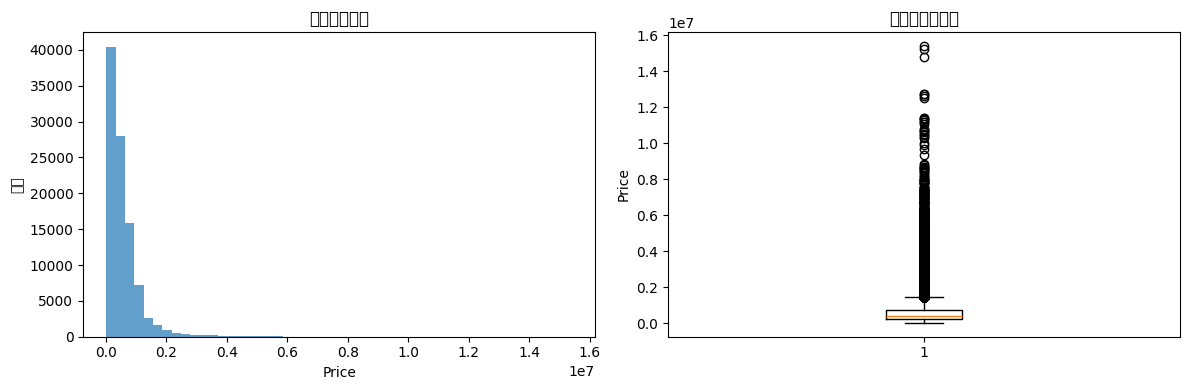


【6. 数据清洗】

6.1 删除无用列:
删除冗余/衍生列: ['district', 'property_category', 'property_description']

6.2 处理Price异常值:
原始Price范围: [17938.07, 15404193.15]
删除Price <= 0的数据: 0 行
IQR异常值边界: [-483272.71, 1449796.34]
检测到 5534 个异常值 (5.60%)
Winsorize处理后Price范围: [92957.86, 3229924.61]

6.3 删除重复数据:
删除 0 行重复数据
数据清洗完成，从 98899 行减少到 98899 行

【7. 数据预处理】

7.1 处理城市:
城市编码保持不变

7.2 处理户型:
户型解析完成 - 提取室数和卫数

7.3 处理装修:
装修状况编码完成 - 精装修=1，其他=0

7.4 处理楼层:
楼层信息解析完成 - 提取当前楼层和总楼层

7.5 处理面积:
面积提取完成

7.6 处理朝向:
朝向信息编码完成

7.7 处理交易时间:
交易时间解析完成

7.8 处理付款方式:
付款方式编码完成

7.9 处理租赁方式:
租赁方式编码完成

7.10 处理电梯:
电梯配置编码完成

7.11 处理车位:
车位配置编码完成

7.12 处理用水:
用水类型编码完成

7.13 处理用电:
用电类型编码完成

7.14 处理燃气:
燃气配置编码完成

7.15 处理采暖:
采暖方式编码完成

7.16 处理租期:
租期解析完成 - 转换为月数

7.17 处理配套设施:
配套设施编码完成

7.18 处理环线位置:
环线位置编码完成

7.19 处理建筑年代:
建筑年代解析完成

7.20 处理房屋总数:
房屋总数提取完成

7.21 处理楼栋总数:
楼栋总数提取完成

7.22 处理绿化率:
绿化率解析完成

7.23 处理物业费:
物业费解析完成

7.24 处理建筑结构:
建筑结构类型编码完成

7.25 处理供水供暖供电:
供水类型编码完成
供暖类型编码完成
供电类型编码完成

7.26 处理费用相关特征:
燃气费解析完成
供热费解析完成
停车费用复杂度编码完成

7.27 处理文本特征:
客户反馈文本特征提取完成

7.2

In [4]:
def rent_data_analysis_cleaning_preprocessing(file_path, output_path=None):
    """
    房租数据分析、清洗和预处理完整流程
    """
    
    print("=" * 60)
    print("Step 1: 房租数据分析、清洗和预处理")
    print("=" * 60)
    
    # ==============================================
    # 1. 读取数据文件
    # ==============================================
    print("\n【1. 读取数据文件】")
    df = pd.read_csv(file_path)
    print(f"原始数据加载完成: {df.shape}")
    
    # ==============================================
    # 2. 将列名重命名为英文（基于房租数据的实际表头）
    # ==============================================
    print("\n【2. 将列名重命名为英文】")
    original_columns = df.columns.tolist()
    print(f"原始列名: {original_columns}")
    
    # 根据房租数据的实际表头进行重命名
    new_columns = ['city', 'house_type', 'decoration', 'Price', 'floor_info', 'area', 'orientation', 
                   'transaction_time', 'payment_method', 'rental_method', 'elevator', 'parking', 
                   'water_usage', 'electricity_usage', 'gas', 'heating', 'lease_term', 
                   'facilities', 'lon', 'lat', 'year', 'district', 'block', 'ring_position', 
                   'property_category', 'construction_year', 'developer', 'total_households', 
                   'total_buildings', 'property_company', 'green_ratio', 'plot_ratio', 
                   'property_fee', 'building_structure', 'property_office', 'property_description', 
                   'water_supply', 'heating_supply', 'electricity_supply', 'gas_fee', 'heating_fee', 
                   'parking_spaces', 'parking_fee', 'coord_x', 'coord_y', 'customer_feedback']
    
    # 确保列名数量匹配
    if len(new_columns) == len(df.columns):
        df.columns = new_columns
        print("列名重命名完成")
    else:
        print(f"警告：新列名数量({len(new_columns)})与原列名数量({len(df.columns)})不匹配")
        print("保持原列名")
    
    # ==============================================
    # 3. 删除数据泄露特征
    # ==============================================
    print("\n【3. 删除数据泄露特征】")
    leakage_columns = ['developer', 'property_company', 'property_office']
    
    for col in leakage_columns:
        if col in df.columns:
            df = df.drop(columns=[col])
            print(f"已删除数据泄露特征: {col}")
    
    print(f"删除数据泄露特征后的数据形状: {df.shape}")
    
    # ==============================================
    # 4. 转换基础数值列
    # ==============================================
    print("\n【4. 转换基础数值列】")
    basic_numeric_cols = ['Price', 'lon', 'lat', 'year', 'parking_spaces', 'coord_x', 'coord_y']
    
    for col in basic_numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # ==============================================
    # 5. 探索性数据分析
    # ==============================================
    print("\n【5. 探索性数据分析】")
    print(f"数据形状: {df.shape}")
    print(f"总样本数: {len(df)}")
    print(f"特征数量: {df.shape[1]}")
    
    # 数据类型概览
    print("\n数据类型分布:")
    print(df.dtypes.value_counts())
    
    # 缺失值分析
    print("\n缺失值分析:")
    missing_info = pd.DataFrame({
        '缺失数量': df.isnull().sum(),
        '缺失比例': df.isnull().sum() / len(df) * 100
    })
    missing_info = missing_info[missing_info['缺失数量'] > 0].sort_values('缺失比例', ascending=False)
    print(missing_info.head(10))
    
    # 目标变量Price分析
    print("\n目标变量Price分析:")
    print(df['Price'].describe())
    print(f"Price偏度: {df['Price'].skew():.3f}")
    print(f"Price峰度: {df['Price'].kurtosis():.3f}")
    
    # Price分布可视化
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df['Price'], bins=50, alpha=0.7)
    plt.title('房租价格分布')
    plt.xlabel('Price')
    plt.ylabel('频次')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(df['Price'])
    plt.title('房租价格箱型图')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()
    
    # ==============================================
    # 6. 数据清洗
    # ==============================================
    print("\n【6. 数据清洗】")
    
    initial_rows = len(df)
    
    # 6.1 删除完全缺失或冗余数据列
    print("\n6.1 删除无用列:")
    
    # 完全缺失的列
    completely_missing = df.columns[df.isnull().all()].tolist()
    if completely_missing:
        df = df.drop(columns=completely_missing)
        print(f"删除完全缺失列: {completely_missing}")
    
    # 删除已知冗余列
    redundant_cols = []
    if 'district' in df.columns:  # 与其他位置信息冗余
        redundant_cols.append('district')
    if 'property_category' in df.columns:  # 衍生特征
        redundant_cols.append('property_category')
    if 'property_description' in df.columns:  # 衍生特征
        redundant_cols.append('property_description')
    
    if redundant_cols:
        df = df.drop(columns=redundant_cols)
        print(f"删除冗余/衍生列: {redundant_cols}")
    
    # 6.2 处理Price异常值
    print("\n6.2 处理Price异常值:")
    print(f"原始Price范围: [{df['Price'].min():.2f}, {df['Price'].max():.2f}]")
    
    # 删除Price <= 0的数据
    before_price_clean = len(df)
    df = df[df['Price'] > 0]
    print(f"删除Price <= 0的数据: {before_price_clean - len(df)} 行")
    
    # 使用IQR方法识别异常值
    Q1 = df['Price'].quantile(0.25)
    Q3 = df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"IQR异常值边界: [{lower_bound:.2f}, {upper_bound:.2f}]")
    outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]
    print(f"检测到 {len(outliers)} 个异常值 ({len(outliers)/len(df)*100:.2f}%)")
    
    # 使用Winsorize处理异常值
    from scipy.stats import mstats
    df['Price'] = mstats.winsorize(df['Price'], limits=[0.01, 0.01])
    print(f"Winsorize处理后Price范围: [{df['Price'].min():.2f}, {df['Price'].max():.2f}]")
    
    # 6.3 删除重复数据
    print("\n6.3 删除重复数据:")
    before_dup = len(df)
    df = df.drop_duplicates()
    print(f"删除 {before_dup - len(df)} 行重复数据")
    
    print(f"数据清洗完成，从 {initial_rows} 行减少到 {len(df)} 行")
    
    # ==============================================
    # 7. 数据预处理
    # ==============================================
    print("\n【7. 数据预处理】")
    
    # 7.1 处理城市（第1列：城市编码，影响地区价格水平）
    print("\n7.1 处理城市:")
    if 'city' in df.columns:
        # 城市已经是数值编码，直接保留
        print("城市编码保持不变")
    
    # 7.2 处理户型（第2列：房屋户型，影响居住空间和价格）
    print("\n7.2 处理户型:")
    def parse_house_type_rent(house_type_str):
        """解析租房户型：提取室数和卫数"""
        if pd.isna(house_type_str):
            return 0, 0
        
        house_type_str = str(house_type_str)
        
        # 初始化室数和卫数
        rooms = 0
        bathrooms = 0
        
        # 提取室数（包括室、厅、房间、居室）
        room_patterns = [
            r'(\d+)室', r'(\d+)厅', r'(\d+)房间', r'(\d+)居室'
        ]
        
        for pattern in room_patterns:
            match = re.search(pattern, house_type_str)
            if match:
                rooms += int(match.group(1))
        
        # 提取卫数
        bathroom_match = re.search(r'(\d+)卫', house_type_str)
        if bathroom_match:
            bathrooms = int(bathroom_match.group(1))
        
        return rooms, bathrooms
    
    if 'house_type' in df.columns:
        df[['rooms_count', 'bathrooms_count']] = pd.DataFrame(
            df['house_type'].apply(lambda x: pd.Series(parse_house_type_rent(x)))
        )
        df = df.drop(['house_type'], axis=1)
        print("户型解析完成 - 提取室数和卫数")
    
    # 7.3 处理装修（第3列：装修状况，影响房屋品质）
    print("\n7.3 处理装修:")
    def parse_decoration_rent(decoration_str):
        """解析装修状况：精装修=1，其他=0"""
        if pd.isna(decoration_str):
            return 0
        
        decoration_str = str(decoration_str)
        return 1 if '精装修' in decoration_str else 0
    
    if 'decoration' in df.columns:
        df['decoration_level'] = df['decoration'].apply(parse_decoration_rent)
        df = df.drop(['decoration'], axis=1)
        print("装修状况编码完成 - 精装修=1，其他=0")
    
    # 7.4 处理楼层（第5列：楼层信息，影响居住便利性）
    print("\n7.4 处理楼层:")
    def parse_floor_info_rent(floor_str):
        """解析楼层信息：提取当前楼层和总楼层"""
        if pd.isna(floor_str):
            return np.nan, np.nan
        
        floor_str = str(floor_str)
        current_floor = np.nan
        total_floors = np.nan
        
        # 处理"X/Y层"格式
        slash_match = re.search(r'(\d+)/(\d+)层', floor_str)
        if slash_match:
            current_floor = int(slash_match.group(1))
            total_floors = int(slash_match.group(2))
            return current_floor, total_floors
        
        # 处理"地下X层"格式
        underground_match = re.search(r'地下(\d+)层', floor_str)
        if underground_match:
            current_floor = -int(underground_match.group(1))
            total_floors = 1
            return current_floor, total_floors
        
        # 处理"地下室/Y层"格式
        basement_match = re.search(r'地下室/(\d+)层', floor_str)
        if basement_match:
            current_floor = -1
            total_floors = int(basement_match.group(1))
            return current_floor, total_floors
        
        # 处理"低楼层/Y层"、"中楼层/Y层"、"高楼层/Y层"格式
        level_match = re.search(r'(低楼层|中楼层|高楼层)/(\d+)层', floor_str)
        if level_match:
            level_type = level_match.group(1)
            total_floors = int(level_match.group(2))
            
            if level_type == '低楼层':
                current_floor = 1
            elif level_type == '中楼层':
                current_floor = total_floors // 2
            elif level_type == '高楼层':
                current_floor = total_floors
            
            return current_floor, total_floors
        
        return current_floor, total_floors
    
    if 'floor_info' in df.columns:
        df[['current_floor', 'total_floors']] = pd.DataFrame(
            df['floor_info'].apply(lambda x: pd.Series(parse_floor_info_rent(x)))
        )
        df = df.drop(['floor_info'], axis=1)
        print("楼层信息解析完成 - 提取当前楼层和总楼层")
    
    # 7.5 处理面积（第6列：房屋面积，直接影响租金）
    print("\n7.5 处理面积:")
    def extract_area_rent(area_str):
        """提取面积数值：从面积字符串中提取数字"""
        if pd.isna(area_str):
            return np.nan
        match = re.search(r'(\d+\.?\d*)', str(area_str))
        return float(match.group(1)) if match else np.nan
    
    if 'area' in df.columns:
        df['area_value'] = df['area'].apply(extract_area_rent)
        df = df.drop(['area'], axis=1)
        print("面积提取完成")
    
    # 7.6 处理朝向（第7列：房屋朝向，影响采光和价格）
    print("\n7.6 处理朝向:")
    def parse_orientation_rent(orientation_str):
        """解析朝向信息：转换为one-hot编码"""
        direction_map = {'东': 'east', '南': 'south', '西': 'west', '北': 'north', 
                        '东北': 'northeast', '东南': 'southeast', '西北': 'northwest', '西南': 'southwest'}
        result = {}
        
        if pd.isna(orientation_str):
            for english in direction_map.values():
                result[f'orientation_{english}'] = 0
        else:
            orientation_str = str(orientation_str)
            for chinese, english in direction_map.items():
                result[f'orientation_{english}'] = 1 if chinese in orientation_str else 0
        
        return result
    
    if 'orientation' in df.columns:
        orientation_features = pd.DataFrame(
            df['orientation'].apply(lambda x: pd.Series(parse_orientation_rent(x)))
        )
        df = pd.concat([df, orientation_features], axis=1)
        df = df.drop(['orientation'], axis=1)
        print("朝向信息编码完成")
    
    # 7.7 处理交易时间（第8列：交易日期，时间因素）
    print("\n7.7 处理交易时间:")
    def parse_date_rent(date_value):
        """解析交易日期：提取年、月、日信息"""
        if pd.isna(date_value):
            return np.nan, np.nan, np.nan
        
        date_str = str(date_value)
        
        try:
            date_obj = pd.to_datetime(date_str)
            return date_obj.year, date_obj.month, date_obj.day
        except:
            pass
        
        match = re.search(r'(\d{4})[/-](\d{1,2})[/-](\d{1,2})', date_str)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
        
        return np.nan, np.nan, np.nan
    
    if 'transaction_time' in df.columns:
        df[['transaction_year', 'transaction_month', 'transaction_day']] = pd.DataFrame(
            df['transaction_time'].apply(lambda x: pd.Series(parse_date_rent(x)))
        )
        df = df.drop(['transaction_time'], axis=1)
        print("交易时间解析完成")
    
    # 7.8 处理付款方式（第9列：付款周期，影响租赁成本）
    print("\n7.8 处理付款方式:")
    def parse_payment_method(payment_str):
        """解析付款方式：不同付款周期对应不同编码"""
        if pd.isna(payment_str):
            return np.nan
        
        payment_str = str(payment_str)
        if '月付' in payment_str:
            return 1
        elif '双月付' in payment_str:
            return 2
        elif '季付' in payment_str:
            return 3
        elif '半年付' in payment_str:
            return 4
        elif '年付' in payment_str:
            return 5
        else:
            return 6
    
    if 'payment_method' in df.columns:
        df['payment_method_encoded'] = df['payment_method'].apply(parse_payment_method)
        df = df.drop(['payment_method'], axis=1)
        print("付款方式编码完成")
    
    # 7.9 处理租赁方式（第10列：租赁类型）
    print("\n7.9 处理租赁方式:")
    def parse_rental_method(rental_str):
        """解析租赁方式：整租=1，合租=2"""
        if pd.isna(rental_str):
            return np.nan
        
        rental_str = str(rental_str)
        if '整租' in rental_str:
            return 1
        elif '合租' in rental_str:
            return 2
        return np.nan
    
    if 'rental_method' in df.columns:
        df['rental_method_encoded'] = df['rental_method'].apply(parse_rental_method)
        df = df.drop(['rental_method'], axis=1)
        print("租赁方式编码完成")
    
    # 7.10 处理电梯（第11列：电梯配置）
    print("\n7.10 处理电梯:")
    def parse_elevator_rent(elevator_str):
        """解析电梯配置：有=1，无=0"""
        if pd.isna(elevator_str):
            return np.nan
        
        elevator_str = str(elevator_str)
        return 1 if '有' in elevator_str else 0
    
    if 'elevator' in df.columns:
        df['elevator_available'] = df['elevator'].apply(parse_elevator_rent)
        df = df.drop(['elevator'], axis=1)
        print("电梯配置编码完成")
    
    # 7.11 处理车位（第12列：停车配置）
    print("\n7.11 处理车位:")
    def parse_parking_rent(parking_str):
        """解析车位配置：免费使用=1，租用车位=2"""
        if pd.isna(parking_str):
            return np.nan
        
        parking_str = str(parking_str)
        if '免费使用' in parking_str:
            return 1
        elif '租用车位' in parking_str:
            return 2
        return np.nan
    
    if 'parking' in df.columns:
        df['parking_type'] = df['parking'].apply(parse_parking_rent)
        df = df.drop(['parking'], axis=1)
        print("车位配置编码完成")
    
    # 7.12 处理用水（第13列：用水类型）
    print("\n7.12 处理用水:")
    def parse_water_usage(water_str):
        """解析用水类型：民水=1，商水=2"""
        if pd.isna(water_str):
            return np.nan
        
        water_str = str(water_str)
        if '民水' in water_str:
            return 1
        elif '商水' in water_str:
            return 2
        return np.nan
    
    if 'water_usage' in df.columns:
        df['water_usage_type'] = df['water_usage'].apply(parse_water_usage)
        df = df.drop(['water_usage'], axis=1)
        print("用水类型编码完成")
    
    # 7.13 处理用电（第14列：用电类型）
    print("\n7.13 处理用电:")
    def parse_electricity_usage(electricity_str):
        """解析用电类型：民电=1，商电=2"""
        if pd.isna(electricity_str):
            return np.nan
        
        electricity_str = str(electricity_str)
        if '民电' in electricity_str:
            return 1
        elif '商电' in electricity_str:
            return 2
        return np.nan
    
    if 'electricity_usage' in df.columns:
        df['electricity_usage_type'] = df['electricity_usage'].apply(parse_electricity_usage)
        df = df.drop(['electricity_usage'], axis=1)
        print("用电类型编码完成")
    
    # 7.14 处理燃气（第15列：燃气配置）
    print("\n7.14 处理燃气:")
    def parse_gas_rent(gas_str):
        """解析燃气配置：有=1，无=0"""
        if pd.isna(gas_str):
            return np.nan
        
        gas_str = str(gas_str)
        return 1 if '有' in gas_str else 0
    
    if 'gas' in df.columns:
        df['gas_available'] = df['gas'].apply(parse_gas_rent)
        df = df.drop(['gas'], axis=1)
        print("燃气配置编码完成")
    
    # 7.15 处理采暖（第16列：采暖方式）
    print("\n7.15 处理采暖:")
    def parse_heating_rent(heating_str):
        """解析采暖方式：集中供暖=1，自采暖=2"""
        if pd.isna(heating_str):
            return np.nan
        
        heating_str = str(heating_str)
        if '集中供暖' in heating_str:
            return 1
        elif '自采暖' in heating_str:
            return 2
        return np.nan
    
    if 'heating' in df.columns:
        df['heating_type'] = df['heating'].apply(parse_heating_rent)
        df = df.drop(['heating'], axis=1)
        print("采暖方式编码完成")
    
    # 7.16 处理租期（第17列：租赁期限）
    print("\n7.16 处理租期:")
    def parse_lease_term(lease_str):
        """解析租期：转换为月数"""
        if pd.isna(lease_str):
            return np.nan
        
        lease_str = str(lease_str)
        
        # 查找"年"关键词
        year_match = re.search(r'(\d+)年', lease_str)
        if year_match:
            years = int(year_match.group(1))
            return years * 12
        
        # 查找范围年份 "X~Y年"
        year_range_match = re.search(r'(\d+)~(\d+)年', lease_str)
        if year_range_match:
            year1 = int(year_range_match.group(1))
            year2 = int(year_range_match.group(2))
            return (year1 + year2) / 2 * 12
        
        # 查找"个月"关键词
        month_match = re.search(r'(\d+)个月', lease_str)
        if month_match:
            months = int(month_match.group(1))
            return months
        
        # 查找范围月份 "X~Y个月"
        month_range_match = re.search(r'(\d+)~(\d+)个月', lease_str)
        if month_range_match:
            month1 = int(month_range_match.group(1))
            month2 = int(month_range_match.group(2))
            return (month1 + month2) / 2
        
        return np.nan
    
    if 'lease_term' in df.columns:
        df['lease_term_months'] = df['lease_term'].apply(parse_lease_term)
        df = df.drop(['lease_term'], axis=1)
        print("租期解析完成 - 转换为月数")
    
    # 7.17 处理配套设施（第18列：家具家电配置）
    print("\n7.17 处理配套设施:")
    def parse_facilities(facilities_str):
        """解析配套设施：提取关键设施"""
        facilities_keywords = ['冰箱', '床', '暖气', '宽带', '天然气', '热水器', '电视', '空调', '衣柜']
        result = {}
        
        if pd.isna(facilities_str):
            for keyword in facilities_keywords:
                result[f'has_{keyword}'] = 0
        else:
            facilities_str = str(facilities_str)
            for keyword in facilities_keywords:
                result[f'has_{keyword}'] = 1 if keyword in facilities_str else 0
        
        return result
    
    if 'facilities' in df.columns:
        facilities_features = pd.DataFrame(
            df['facilities'].apply(lambda x: pd.Series(parse_facilities(x)))
        )
        df = pd.concat([df, facilities_features], axis=1)
        df = df.drop(['facilities'], axis=1)
        print("配套设施编码完成")
    
    # 7.18-7.46 处理剩余特征（与房价数据处理方法相同）
    print("\n7.18 处理环线位置:")
    def parse_ring_rent(ring_str):
        """解析环线信息：将环线位置转换为数字编码"""
        if pd.isna(ring_str):
            return np.nan
        
        ring_str = str(ring_str)
        ring_mapping = {
            '二环内': 1, '二至三环': 2, '三至四环': 3, '四至五环': 4, 
            '五至六环': 5, '六环外': 6, '内环内': 2, '内环至中环': 3, 
            '内环至外环': 4, '中环至外环': 5, '外环外': 6
        }
        
        for key, value in ring_mapping.items():
            if key in ring_str:
                return value
        return np.nan
    
    if 'ring_position' in df.columns:
        df['ring_encoded'] = df['ring_position'].apply(parse_ring_rent)
        df = df.drop(['ring_position'], axis=1)
        print("环线位置编码完成")
    
    # 7.19 处理建筑年代
    print("\n7.19 处理建筑年代:")
    def parse_construction_year_rent(year_str):
        """解析建造年份"""
        if pd.isna(year_str):
            return np.nan
        
        year_str = str(year_str)
        
        single_year = re.search(r'(\d{4})年', year_str)
        if single_year:
            return int(single_year.group(1))
        
        range_year = re.search(r'(\d{4})-(\d{4})年', year_str)
        if range_year:
            start_year = int(range_year.group(1))
            end_year = int(range_year.group(2))
            return (start_year + end_year) // 2
        
        return np.nan
    
    if 'construction_year' in df.columns:
        df['construction_year_value'] = df['construction_year'].apply(parse_construction_year_rent)
        df = df.drop(['construction_year'], axis=1)
        print("建筑年代解析完成")
    
    # 7.20 处理房屋总数
    print("\n7.20 处理房屋总数:")
    def extract_households_rent(households_str):
        """提取总户数"""
        if pd.isna(households_str):
            return np.nan
        
        households_str = str(households_str)
        match = re.search(r'(\d+)户', households_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_households' in df.columns:
        df['total_households_value'] = df['total_households'].apply(extract_households_rent)
        df = df.drop(['total_households'], axis=1)
        print("房屋总数提取完成")
    
    # 7.21 处理楼栋总数
    print("\n7.21 处理楼栋总数:")
    def extract_buildings_rent(buildings_str):
        """提取总楼栋数"""
        if pd.isna(buildings_str):
            return np.nan
        
        buildings_str = str(buildings_str)
        match = re.search(r'(\d+)栋', buildings_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_buildings' in df.columns:
        df['total_buildings_value'] = df['total_buildings'].apply(extract_buildings_rent)
        df = df.drop(['total_buildings'], axis=1)
        print("楼栋总数提取完成")
    
    # 7.22 处理绿化率
    print("\n7.22 处理绿化率:")
    def parse_green_ratio_rent(ratio_str):
        """解析绿化率百分比"""
        if pd.isna(ratio_str):
            return np.nan
        
        ratio_str = str(ratio_str)
        match = re.search(r'(\d+\.?\d*)%', ratio_str)
        return float(match.group(1)) / 100 if match else np.nan
    
    if 'green_ratio' in df.columns:
        df['green_ratio_value'] = df['green_ratio'].apply(parse_green_ratio_rent)
        df = df.drop(['green_ratio'], axis=1)
        print("绿化率解析完成")
    
    # 7.23 处理物业费
    print("\n7.23 处理物业费:")
    def parse_property_fee_rent(fee_str):
        """解析物业费"""
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/月/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        single_match = re.search(r'(\d+\.?\d*)元/月/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'property_fee' in df.columns:
        df['property_fee_value'] = df['property_fee'].apply(parse_property_fee_rent)
        df = df.drop(['property_fee'], axis=1)
        print("物业费解析完成")
    
    # 7.24 处理建筑结构
    print("\n7.24 处理建筑结构:")
    def parse_building_structure_rent(structure_str):
        """解析建筑结构类型关键词"""
        if pd.isna(structure_str):
            return {'板楼': 0, '平房': 0, '塔板结合': 0, '塔楼': 0}
        
        structure_str = str(structure_str)
        return {
            '板楼': 1 if '板楼' in structure_str else 0,
            '平房': 1 if '平房' in structure_str else 0,
            '塔板结合': 1 if '塔板结合' in structure_str else 0,
            '塔楼': 1 if '塔楼' in structure_str else 0
        }
    
    if 'building_structure' in df.columns:
        structure_features = pd.DataFrame(
            df['building_structure'].apply(lambda x: pd.Series(parse_building_structure_rent(x)))
        )
        structure_features.columns = ['has_banlou', 'has_pingfang', 'has_tabanjiehe', 'has_talou']
        df = pd.concat([df, structure_features], axis=1)
        df = df.drop(['building_structure'], axis=1)
        print("建筑结构类型编码完成")
    
    # 7.25 处理供水供暖供电（与房价数据处理方法相同）
    print("\n7.25 处理供水供暖供电:")
    
    # 供水
    def parse_water_supply_rent(water_str):
        if pd.isna(water_str):
            return np.nan
        water_str = str(water_str)
        if water_str == '民水':
            return 1
        elif water_str == '商水':
            return 2
        elif water_str == '商水/民水':
            return 3
        return np.nan
    
    if 'water_supply' in df.columns:
        df['water_supply_encoded'] = df['water_supply'].apply(parse_water_supply_rent)
        df = df.drop(['water_supply'], axis=1)
        print("供水类型编码完成")
    
    # 供暖
    def parse_heating_supply_rent(heating_str):
        if pd.isna(heating_str):
            return np.nan
        heating_str = str(heating_str)
        heating_mapping = { 
            '无供暖': 0,
            '自采暖/无供暖': 1,
            '自采暖': 2,
            '集中供暖': 3,
            '集中供暖/自采暖/无供暖': 4,
            '集中供暖/自采暖': 5
        }
        return heating_mapping.get(heating_str, np.nan)
    
    if 'heating_supply' in df.columns:
        df['heating_supply_encoded'] = df['heating_supply'].apply(parse_heating_supply_rent)
        df = df.drop(['heating_supply'], axis=1)
        print("供暖类型编码完成")
    
    # 供电
    def parse_electricity_supply_rent(electricity_str):
        if pd.isna(electricity_str):
            return np.nan
        electricity_str = str(electricity_str)
        if electricity_str == '民电':
            return 1
        elif electricity_str == '商电':
            return 2
        elif electricity_str == '商电/民电':
            return 3
        return np.nan
    
    if 'electricity_supply' in df.columns:
        df['electricity_supply_encoded'] = df['electricity_supply'].apply(parse_electricity_supply_rent)
        df = df.drop(['electricity_supply'], axis=1)
        print("供电类型编码完成")
    
    # 7.26 处理费用相关特征
    print("\n7.26 处理费用相关特征:")
    
    # 燃气费
    def parse_gas_fee_rent(fee_str):
        if pd.isna(fee_str):
            return np.nan
        fee_str = str(fee_str)
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/m³', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        single_match = re.search(r'(\d+\.?\d*)元/m³', fee_str)
        if single_match:
            return float(single_match.group(1))
        return np.nan
    
    if 'gas_fee' in df.columns:
        df['gas_fee_value'] = df['gas_fee'].apply(parse_gas_fee_rent)
        df = df.drop(['gas_fee'], axis=1)
        print("燃气费解析完成")
    
    # 供热费
    def parse_heating_fee_rent(fee_str):
        if pd.isna(fee_str):
            return np.nan
        fee_str = str(fee_str)
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        single_match = re.search(r'(\d+\.?\d*)元/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        return np.nan
    
    if 'heating_fee' in df.columns:
        df['heating_fee_value'] = df['heating_fee'].apply(parse_heating_fee_rent)
        df = df.drop(['heating_fee'], axis=1)
        print("供热费解析完成")
    
    # 停车费用处理
    if 'parking_fee' in df.columns:
        # 停车费用比较复杂，简单处理为字符串长度
        df['parking_fee_complexity'] = df['parking_fee'].astype(str).str.len()
        df = df.drop(['parking_fee'], axis=1)
        print("停车费用复杂度编码完成")
    
    # 7.27 处理文本特征
    print("\n7.27 处理文本特征:")
    if 'customer_feedback' in df.columns:
        df['feedback_length'] = df['customer_feedback'].astype(str).str.len()
        df['feedback_word_count'] = df['customer_feedback'].astype(str).str.split().str.len()
        df = df.drop(['customer_feedback'], axis=1)
        print("客户反馈文本特征提取完成")
    
    # 7.28 处理缺失值
    print("\n7.28 处理缺失值:")
    
    # 处理数值特征的缺失值
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'Price' in numeric_cols:
        numeric_cols.remove('Price')
    
    print(f"数值特征数量: {len(numeric_cols)}")
    
    for col in numeric_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  {col}: 用中位数 {median_val:.2f} 填充")
    
    # 处理分类特征的缺失值
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"分类特征数量: {len(categorical_cols)}")
    
    for col in categorical_cols:
        if df[col].isnull().any():
            if len(df[col].mode()) > 0:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  {col}: 用众数 '{mode_val}' 填充")
            else:
                df[col] = df[col].fillna('Unknown')
                print(f"  {col}: 用 'Unknown' 填充")
    
    # 7.29 特征工程
    print("\n7.29 特征工程:")
    
    # 房龄特征
    if 'construction_year_value' in df.columns:
        df['calculated_house_age'] = 2024 - df['construction_year_value']
        print("创建房龄特征")
    
    # 楼层比例特征
    if 'current_floor' in df.columns and 'total_floors' in df.columns:
        df['floor_ratio'] = df['current_floor'] / df['total_floors']
        df['floor_ratio'] = df['floor_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        print("创建楼层比例特征")
    
    # 地理特征 - 到市中心距离
    if 'lat' in df.columns and 'lon' in df.columns:
        center_lat, center_lon = 39.9042, 116.4074
        df['distance_to_center'] = np.sqrt((df['lat'] - center_lat)**2 + (df['lon'] - center_lon)**2)
        print("创建到市中心距离特征")
    
    # 时间特征
    if all(col in df.columns for col in ['transaction_year', 'transaction_month', 'transaction_day']):
        try:
            df['transaction_date_complete'] = pd.to_datetime(df[['transaction_year', 'transaction_month', 'transaction_day']], errors='coerce')
            reference_date = pd.Timestamp('2024-10-27')
            df['days_to_today'] = (reference_date - df['transaction_date_complete']).dt.days
            df = df.drop(['transaction_date_complete'], axis=1)
            print("创建距今天数特征")
        except:
            print("创建交易日期特征失败")
    
    # 7.30 最终数据质量检查
    print("\n7.30 最终数据质量检查:")
    print(f"最终数据形状: {df.shape}")
    print(f"剩余缺失值: {df.isnull().sum().sum()}")
    
    # 检查无穷值
    inf_cols = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
    if inf_cols:
        print(f"包含无穷值的列: {inf_cols}")
        for col in inf_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].median())
        print("处理无穷值完成")
    
    # ==============================================
    # 8. 保存处理后的数据
    # ==============================================
    print("\n【8. 保存处理后的数据】")
    
    if output_path is None:
        base_name = file_path.replace('.csv', '')
        output_path = f"{base_name}_processed.csv"
    
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"处理后数据保存至: {output_path}")
    print(f"保存数据形状: {df.shape}")
    
    # 显示处理后数据的前几行
    print("\n处理后数据前5行:")
    print(df.head())
    
    # 显示列信息
    print("\n列信息:")
    print(f"总列数: {len(df.columns)}")
    print("列名:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    print("\n房租数据分析、清洗和预处理完成!")
    print("=" * 60)
    
    print("=" * 60)
    print("Step 2: 数据集分割")
    print("=" * 60)
    
    # 分离特征和目标变量
    X = df.drop('Price', axis=1)
    y = df['Price']
    
    print(f"特征矩阵 X 形状: {X.shape}")
    print(f"目标变量 y 形状: {y.shape}")
    
    # 数据分割：80%训练集，20%测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=111
    )
    
    print(f"\n数据分割结果:")
    print(f"训练集 X_train 形状: {X_train.shape}")
    print(f"训练集 y_train 形状: {y_train.shape}")
    print(f"测试集 X_test 形状: {X_test.shape}")
    print(f"测试集 y_test 形状: {y_test.shape}")
    
    # 验证分割比例
    train_ratio = len(X_train) / len(X)
    test_ratio = len(X_test) / len(X)
    print(f"\n分割比例验证:")
    print(f"训练集比例: {train_ratio:.1%}")
    print(f"测试集比例: {test_ratio:.1%}")
    
    print("\n=== 房租数据处理workflow前2步完成 ===")
    print("✅ (1) 数据分析、清洗和预处理（包含删除数据泄露特征）")
    print("✅ (2) 数据集分割（80%训练，20%测试）")
    
    # 返回分割后的数据集
    return X_train, X_test, y_train, y_test, df

# 调用函数处理房租数据
rent_X_train, rent_X_test, rent_y_train, rent_y_test, rent_df_processed = rent_data_analysis_cleaning_preprocessing('ruc_Class25Q2_train_rent.csv')


### 4. Test Rent

In [5]:
def rent_validation_data_preprocessing(file_path, output_path=None):
    """
    房租验证集数据分析、清洗和预处理完整流程
    """
    
    print("=" * 60)
    print("Step 1: 房租验证集数据分析、清洗和预处理")
    print("=" * 60)
    
    # ==============================================
    # 1. 读取数据文件
    # ==============================================
    print("\n【1. 读取数据文件】")
    df = pd.read_csv(file_path)
    print(f"原始数据加载完成: {df.shape}")

    # 保存ID列用于最终输出
    validation_ids = df['ID'].copy()
    print(f"保存验证集ID: {len(validation_ids)} 个样本")
    
    # ==============================================
    # 2. 将列名重命名为英文（基于房租数据的实际表头）
    # ==============================================
    print("\n【2. 将列名重命名为英文】")
    new_columns = ['ID', 'city', 'house_type', 'decoration', 'floor_info', 'area', 'orientation', 
                   'transaction_time', 'payment_method', 'rental_method', 'elevator', 'parking', 
                   'water_usage', 'electricity_usage', 'gas', 'heating', 'lease_term', 
                   'facilities', 'lon', 'lat', 'year', 'district', 'block', 'ring_position', 
                   'property_category', 'construction_year', 'developer', 'total_households', 
                   'total_buildings', 'property_company', 'green_ratio', 'plot_ratio', 
                   'property_fee', 'building_structure', 'property_office', 'property_description', 
                   'water_supply', 'heating_supply', 'electricity_supply', 'gas_fee', 'heating_fee', 
                   'parking_spaces', 'parking_fee', 'coord_x', 'coord_y', 'customer_feedback']
    
    if len(new_columns) == len(df.columns):
        df.columns = new_columns
        print("列名重命名完成")
    else:
        print(f"警告：新列名数量({len(new_columns)})与原列名数量({len(df.columns)})不匹配")
        print("保持原列名")
    
    # ==============================================
    # 3. 删除数据泄露特征
    # ==============================================
    print("\n【3. 删除数据泄露特征】")
    leakage_columns = ['developer', 'property_company', 'property_office']
    
    for col in leakage_columns:
        if col in df.columns:
            df = df.drop(columns=[col])
            print(f"已删除数据泄露特征: {col}")
    
    print(f"删除数据泄露特征后的数据形状: {df.shape}")
    
    # ==============================================
    # 4. 转换基础数值列
    # ==============================================
    print("\n【4. 转换基础数值列】")
    basic_numeric_cols = ['lon', 'lat', 'year', 'parking_spaces', 'coord_x', 'coord_y']
    
    for col in basic_numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # ==============================================
    # 5. 探索性数据分析
    # ==============================================
    print("\n【5. 探索性数据分析】")
    print(f"数据形状: {df.shape}")
    print(f"总样本数: {len(df)}")
    print(f"特征数量: {df.shape[1]}")
    
    # 数据类型概览
    print("\n数据类型分布:")
    print(df.dtypes.value_counts())
    
    # 缺失值分析
    print("\n缺失值分析:")
    missing_info = pd.DataFrame({
        '缺失数量': df.isnull().sum(),
        '缺失比例': df.isnull().sum() / len(df) * 100
    })
    missing_info = missing_info[missing_info['缺失数量'] > 0].sort_values('缺失比例', ascending=False)
    print(missing_info.head(10))
    
    # ==============================================
    # 6. 数据清洗
    # ==============================================
    print("\n【6. 数据清洗】")
    
    # 6.1 删除完全缺失或冗余数据列
    print("\n6.1 删除无用列:")
    
    # 完全缺失的列
    completely_missing = df.columns[df.isnull().all()].tolist()
    if completely_missing:
        df = df.drop(columns=completely_missing)
        print(f"删除完全缺失列: {completely_missing}")
    
    # 删除已知冗余列
    redundant_cols = []
    if 'district' in df.columns:
        redundant_cols.append('district')
    if 'property_category' in df.columns:
        redundant_cols.append('property_category')
    if 'property_description' in df.columns:
        redundant_cols.append('property_description')
    
    if redundant_cols:
        df = df.drop(columns=redundant_cols)
        print(f"删除冗余/衍生列: {redundant_cols}")
    
    # 6.2 删除重复数据
    print("\n6.3 删除重复数据:")
    before_dup = len(df)
    df = df.drop_duplicates()
    print(f"删除 {before_dup - len(df)} 行重复数据")
    
    print(f"数据清洗完成，从 {before_dup} 行减少到 {len(df)} 行")
    
    # ==============================================
    # 7. 数据预处理
    # ==============================================
    print("\n【7. 数据预处理】")
    
    # 7.1 处理城市
    print("\n7.1 处理城市:")
    if 'city' in df.columns:
        print("城市编码保持不变")
    
    # 7.2 处理户型
    print("\n7.2 处理户型:")
    def parse_house_type_rent(house_type_str):
        if pd.isna(house_type_str):
            return 0, 0
        
        house_type_str = str(house_type_str)
        rooms = 0
        bathrooms = 0
        
        room_patterns = [
            r'(\d+)室', r'(\d+)厅', r'(\d+)房间', r'(\d+)居室'
        ]
        
        for pattern in room_patterns:
            match = re.search(pattern, house_type_str)
            if match:
                rooms += int(match.group(1))
        
        bathroom_match = re.search(r'(\d+)卫', house_type_str)
        if bathroom_match:
            bathrooms = int(bathroom_match.group(1))
        
        return rooms, bathrooms
    
    if 'house_type' in df.columns:
        df[['rooms_count', 'bathrooms_count']] = pd.DataFrame(
            df['house_type'].apply(lambda x: pd.Series(parse_house_type_rent(x)))
        )
        df = df.drop(['house_type'], axis=1)
        print("户型解析完成 - 提取室数和卫数")
    
    # 7.3 处理装修
    print("\n7.3 处理装修:")
    def parse_decoration_rent(decoration_str):
        if pd.isna(decoration_str):
            return 0
        decoration_str = str(decoration_str)
        return 1 if '精装修' in decoration_str else 0
    
    if 'decoration' in df.columns:
        df['decoration_level'] = df['decoration'].apply(parse_decoration_rent)
        df = df.drop(['decoration'], axis=1)
        print("装修状况编码完成 - 精装修=1，其他=0")
    
    # 7.4 处理楼层
    print("\n7.4 处理楼层:")
    def parse_floor_info_rent(floor_str):
        if pd.isna(floor_str):
            return np.nan, np.nan
        
        floor_str = str(floor_str)
        current_floor = np.nan
        total_floors = np.nan
        
        slash_match = re.search(r'(\d+)/(\d+)层', floor_str)
        if slash_match:
            current_floor = int(slash_match.group(1))
            total_floors = int(slash_match.group(2))
            return current_floor, total_floors
        
        underground_match = re.search(r'地下(\d+)层', floor_str)
        if underground_match:
            current_floor = -int(underground_match.group(1))
            total_floors = 1
            return current_floor, total_floors
        
        basement_match = re.search(r'地下室/(\d+)层', floor_str)
        if basement_match:
            current_floor = -1
            total_floors = int(basement_match.group(1))
            return current_floor, total_floors
        
        level_match = re.search(r'(低楼层|中楼层|高楼层)/(\d+)层', floor_str)
        if level_match:
            level_type = level_match.group(1)
            total_floors = int(level_match.group(2))
            
            if level_type == '低楼层':
                current_floor = 1
            elif level_type == '中楼层':
                current_floor = total_floors // 2
            elif level_type == '高楼层':
                current_floor = total_floors
            
            return current_floor, total_floors
        
        return current_floor, total_floors
    
    if 'floor_info' in df.columns:
        df[['current_floor', 'total_floors']] = pd.DataFrame(
            df['floor_info'].apply(lambda x: pd.Series(parse_floor_info_rent(x)))
        )
        df = df.drop(['floor_info'], axis=1)
        print("楼层信息解析完成 - 提取当前楼层和总楼层")
    
    # 7.5 处理面积
    print("\n7.5 处理面积:")
    def extract_area_rent(area_str):
        if pd.isna(area_str):
            return np.nan
        match = re.search(r'(\d+\.?\d*)', str(area_str))
        return float(match.group(1)) if match else np.nan
    
    if 'area' in df.columns:
        df['area_value'] = df['area'].apply(extract_area_rent)
        df = df.drop(['area'], axis=1)
        print("面积提取完成")
    
    # 7.6 处理朝向
    print("\n7.6 处理朝向:")
    def parse_orientation_rent(orientation_str):
        direction_map = {'东': 'east', '南': 'south', '西': 'west', '北': 'north', 
                        '东北': 'northeast', '东南': 'southeast', '西北': 'northwest', '西南': 'southwest'}
        result = {}
        
        if pd.isna(orientation_str):
            for english in direction_map.values():
                result[f'orientation_{english}'] = 0
        else:
            orientation_str = str(orientation_str)
            for chinese, english in direction_map.items():
                result[f'orientation_{english}'] = 1 if chinese in orientation_str else 0
        
        return result
    
    if 'orientation' in df.columns:
        orientation_features = pd.DataFrame(
            df['orientation'].apply(lambda x: pd.Series(parse_orientation_rent(x)))
        )
        df = pd.concat([df, orientation_features], axis=1)
        df = df.drop(['orientation'], axis=1)
        print("朝向信息编码完成")
    
    # 7.7 处理交易时间
    print("\n7.7 处理交易时间:")
    def parse_date_rent(date_value):
        if pd.isna(date_value):
            return np.nan, np.nan, np.nan
        
        date_str = str(date_value)
        
        try:
            date_obj = pd.to_datetime(date_str)
            return date_obj.year, date_obj.month, date_obj.day
        except:
            pass
        
        match = re.search(r'(\d{4})[/-](\d{1,2})[/-](\d{1,2})', date_str)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
        
        return np.nan, np.nan, np.nan
    
    if 'transaction_time' in df.columns:
        df[['transaction_year', 'transaction_month', 'transaction_day']] = pd.DataFrame(
            df['transaction_time'].apply(lambda x: pd.Series(parse_date_rent(x)))
        )
        df = df.drop(['transaction_time'], axis=1)
        print("交易时间解析完成")
    
    # 7.8 处理付款方式
    print("\n7.8 处理付款方式:")
    def parse_payment_method(payment_str):
        if pd.isna(payment_str):
            return np.nan
        
        payment_str = str(payment_str)
        if '月付' in payment_str:
            return 1
        elif '双月付' in payment_str:
            return 2
        elif '季付' in payment_str:
            return 3
        elif '半年付' in payment_str:
            return 4
        elif '年付' in payment_str:
            return 5
        else:
            return 6
    
    if 'payment_method' in df.columns:
        df['payment_method_encoded'] = df['payment_method'].apply(parse_payment_method)
        df = df.drop(['payment_method'], axis=1)
        print("付款方式编码完成")
    
    # 7.9 处理租赁方式
    print("\n7.9 处理租赁方式:")
    def parse_rental_method(rental_str):
        if pd.isna(rental_str):
            return np.nan
        
        rental_str = str(rental_str)
        if '整租' in rental_str:
            return 1
        elif '合租' in rental_str:
            return 2
        return np.nan
    
    if 'rental_method' in df.columns:
        df['rental_method_encoded'] = df['rental_method'].apply(parse_rental_method)
        df = df.drop(['rental_method'], axis=1)
        print("租赁方式编码完成")
    
    # 7.10 处理电梯
    print("\n7.10 处理电梯:")
    def parse_elevator_rent(elevator_str):
        if pd.isna(elevator_str):
            return np.nan
        
        elevator_str = str(elevator_str)
        return 1 if '有' in elevator_str else 0
    
    if 'elevator' in df.columns:
        df['elevator_available'] = df['elevator'].apply(parse_elevator_rent)
        df = df.drop(['elevator'], axis=1)
        print("电梯配置编码完成")
    
    # 7.11 处理车位
    print("\n7.11 处理车位:")
    def parse_parking_rent(parking_str):
        if pd.isna(parking_str):
            return np.nan
        
        parking_str = str(parking_str)
        if '免费使用' in parking_str:
            return 1
        elif '租用车位' in parking_str:
            return 2
        return np.nan
    
    if 'parking' in df.columns:
        df['parking_type'] = df['parking'].apply(parse_parking_rent)
        df = df.drop(['parking'], axis=1)
        print("车位配置编码完成")
    
    # 7.12 处理用水
    print("\n7.12 处理用水:")
    def parse_water_usage(water_str):
        if pd.isna(water_str):
            return np.nan
        
        water_str = str(water_str)
        if '民水' in water_str:
            return 1
        elif '商水' in water_str:
            return 2
        return np.nan
    
    if 'water_usage' in df.columns:
        df['water_usage_type'] = df['water_usage'].apply(parse_water_usage)
        df = df.drop(['water_usage'], axis=1)
        print("用水类型编码完成")
    
    # 7.13 处理用电
    print("\n7.13 处理用电:")
    def parse_electricity_usage(electricity_str):
        if pd.isna(electricity_str):
            return np.nan
        
        electricity_str = str(electricity_str)
        if '民电' in electricity_str:
            return 1
        elif '商电' in electricity_str:
            return 2
        return np.nan
    
    if 'electricity_usage' in df.columns:
        df['electricity_usage_type'] = df['electricity_usage'].apply(parse_electricity_usage)
        df = df.drop(['electricity_usage'], axis=1)
        print("用电类型编码完成")
    
    # 7.14 处理燃气
    print("\n7.14 处理燃气:")
    def parse_gas_rent(gas_str):
        if pd.isna(gas_str):
            return np.nan
        
        gas_str = str(gas_str)
        return 1 if '有' in gas_str else 0
    
    if 'gas' in df.columns:
        df['gas_available'] = df['gas'].apply(parse_gas_rent)
        df = df.drop(['gas'], axis=1)
        print("燃气配置编码完成")
    
    # 7.15 处理采暖
    print("\n7.15 处理采暖:")
    def parse_heating_rent(heating_str):
        if pd.isna(heating_str):
            return np.nan
        
        heating_str = str(heating_str)
        if '集中供暖' in heating_str:
            return 1
        elif '自采暖' in heating_str:
            return 2
        return np.nan
    
    if 'heating' in df.columns:
        df['heating_type'] = df['heating'].apply(parse_heating_rent)
        df = df.drop(['heating'], axis=1)
        print("采暖方式编码完成")
    
    # 7.16 处理租期
    print("\n7.16 处理租期:")
    def parse_lease_term(lease_str):
        if pd.isna(lease_str):
            return np.nan
        
        lease_str = str(lease_str)
        
        year_match = re.search(r'(\d+)年', lease_str)
        if year_match:
            years = int(year_match.group(1))
            return years * 12
        
        year_range_match = re.search(r'(\d+)~(\d+)年', lease_str)
        if year_range_match:
            year1 = int(year_range_match.group(1))
            year2 = int(year_range_match.group(2))
            return (year1 + year2) / 2 * 12
        
        month_match = re.search(r'(\d+)个月', lease_str)
        if month_match:
            months = int(month_match.group(1))
            return months
        
        month_range_match = re.search(r'(\d+)~(\d+)个月', lease_str)
        if month_range_match:
            month1 = int(month_range_match.group(1))
            month2 = int(month_range_match.group(2))
            return (month1 + month2) / 2
        
        return np.nan
    
    if 'lease_term' in df.columns:
        df['lease_term_months'] = df['lease_term'].apply(parse_lease_term)
        df = df.drop(['lease_term'], axis=1)
        print("租期解析完成 - 转换为月数")
    
    # 7.17 处理配套设施
    print("\n7.17 处理配套设施:")
    def parse_facilities(facilities_str):
        facilities_keywords = ['冰箱', '床', '暖气', '宽带', '天然气', '热水器', '电视', '空调', '衣柜']
        result = {}
        
        if pd.isna(facilities_str):
            for keyword in facilities_keywords:
                result[f'has_{keyword}'] = 0
        else:
            facilities_str = str(facilities_str)
            for keyword in facilities_keywords:
                result[f'has_{keyword}'] = 1 if keyword in facilities_str else 0
        
        return result
    
    if 'facilities' in df.columns:
        facilities_features = pd.DataFrame(
            df['facilities'].apply(lambda x: pd.Series(parse_facilities(x)))
        )
        df = pd.concat([df, facilities_features], axis=1)
        df = df.drop(['facilities'], axis=1)
        print("配套设施编码完成")
    
    # 7.18-7.26 处理剩余特征（与房租训练集数据处理方法相同）
    print("\n7.18 处理环线位置:")
    def parse_ring_rent(ring_str):
        if pd.isna(ring_str):
            return np.nan
        
        ring_str = str(ring_str)
        ring_mapping = {
            '二环内': 1, '二至三环': 2, '三至四环': 3, '四至五环': 4, 
            '五至六环': 5, '六环外': 6, '内环内': 2, '内环至中环': 3, 
            '内环至外环': 4, '中环至外环': 5, '外环外': 6
        }
        
        for key, value in ring_mapping.items():
            if key in ring_str:
                return value
        return np.nan
    
    if 'ring_position' in df.columns:
        df['ring_encoded'] = df['ring_position'].apply(parse_ring_rent)
        df = df.drop(['ring_position'], axis=1)
        print("环线位置编码完成")
    
    # 7.19 处理建筑年代
    print("\n7.19 处理建筑年代:")
    def parse_construction_year_rent(year_str):
        if pd.isna(year_str):
            return np.nan
        
        year_str = str(year_str)
        
        single_year = re.search(r'(\d{4})年', year_str)
        if single_year:
            return int(single_year.group(1))
        
        range_year = re.search(r'(\d{4})-(\d{4})年', year_str)
        if range_year:
            start_year = int(range_year.group(1))
            end_year = int(range_year.group(2))
            return (start_year + end_year) // 2
        
        return np.nan
    
    if 'construction_year' in df.columns:
        df['construction_year_value'] = df['construction_year'].apply(parse_construction_year_rent)
        df = df.drop(['construction_year'], axis=1)
        print("建筑年代解析完成")
    
    # 7.20 处理房屋总数
    print("\n7.20 处理房屋总数:")
    def extract_households_rent(households_str):
        if pd.isna(households_str):
            return np.nan
        
        households_str = str(households_str)
        match = re.search(r'(\d+)户', households_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_households' in df.columns:
        df['total_households_value'] = df['total_households'].apply(extract_households_rent)
        df = df.drop(['total_households'], axis=1)
        print("房屋总数提取完成")
    
    # 7.21 处理楼栋总数
    print("\n7.21 处理楼栋总数:")
    def extract_buildings_rent(buildings_str):
        if pd.isna(buildings_str):
            return np.nan
        
        buildings_str = str(buildings_str)
        match = re.search(r'(\d+)栋', buildings_str)
        return int(match.group(1)) if match else np.nan
    
    if 'total_buildings' in df.columns:
        df['total_buildings_value'] = df['total_buildings'].apply(extract_buildings_rent)
        df = df.drop(['total_buildings'], axis=1)
        print("楼栋总数提取完成")
    
    # 7.22 处理绿化率
    print("\n7.22 处理绿化率:")
    def parse_green_ratio_rent(ratio_str):
        if pd.isna(ratio_str):
            return np.nan
        
        ratio_str = str(ratio_str)
        match = re.search(r'(\d+\.?\d*)%', ratio_str)
        return float(match.group(1)) / 100 if match else np.nan
    
    if 'green_ratio' in df.columns:
        df['green_ratio_value'] = df['green_ratio'].apply(parse_green_ratio_rent)
        df = df.drop(['green_ratio'], axis=1)
        print("绿化率解析完成")
    
    # 7.23 处理物业费
    print("\n7.23 处理物业费:")
    def parse_property_fee_rent(fee_str):
        if pd.isna(fee_str):
            return np.nan
        
        fee_str = str(fee_str)
        
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/月/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        
        single_match = re.search(r'(\d+\.?\d*)元/月/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        
        return np.nan
    
    if 'property_fee' in df.columns:
        df['property_fee_value'] = df['property_fee'].apply(parse_property_fee_rent)
        df = df.drop(['property_fee'], axis=1)
        print("物业费解析完成")
    
    # 7.24 处理建筑结构
    print("\n7.24 处理建筑结构:")
    def parse_building_structure_rent(structure_str):
        if pd.isna(structure_str):
            return {'has_banlou': 0, 'has_pingfang': 0, 'has_tabanjiehe': 0, 'has_talou': 0}
        
        structure_str = str(structure_str)
        return {
            'has_banlou': 1 if '板楼' in structure_str else 0,
            'has_pingfang': 1 if '平房' in structure_str else 0,
            'has_tabanjiehe': 1 if '塔板结合' in structure_str else 0,
            'has_talou': 1 if '塔楼' in structure_str else 0
        }
    
    if 'building_structure' in df.columns:
        structure_features = pd.DataFrame(
            df['building_structure'].apply(lambda x: pd.Series(parse_building_structure_rent(x)))
        )
        df = pd.concat([df, structure_features], axis=1)
        df = df.drop(['building_structure'], axis=1)
        print("建筑结构类型编码完成")
    
    # 7.25 处理供水供暖供电
    print("\n7.25 处理供水供暖供电:")
    
    # 供水
    def parse_water_supply_rent(water_str):
        if pd.isna(water_str):
            return np.nan
        water_str = str(water_str)
        if water_str == '民水':
            return 1
        elif water_str == '商水':
            return 2
        elif water_str == '商水/民水':
            return 3
        return np.nan
    
    if 'water_supply' in df.columns:
        df['water_supply_encoded'] = df['water_supply'].apply(parse_water_supply_rent)
        df = df.drop(['water_supply'], axis=1)
        print("供水类型编码完成")
    
    # 供暖
    def parse_heating_supply_rent(heating_str):
        if pd.isna(heating_str):
            return np.nan
        heating_str = str(heating_str)
        heating_mapping = { 
            '无供暖': 0,
            '自采暖/无供暖': 1,
            '自采暖': 2,
            '集中供暖': 3,
            '集中供暖/自采暖/无供暖': 4,
            '集中供暖/自采暖': 5
        }
        return heating_mapping.get(heating_str, np.nan)
    
    if 'heating_supply' in df.columns:
        df['heating_supply_encoded'] = df['heating_supply'].apply(parse_heating_supply_rent)
        df = df.drop(['heating_supply'], axis=1)
        print("供暖类型编码完成")
    
    # 供电
    def parse_electricity_supply_rent(electricity_str):
        if pd.isna(electricity_str):
            return np.nan
        electricity_str = str(electricity_str)
        if electricity_str == '民电':
            return 1
        elif electricity_str == '商电':
            return 2
        elif electricity_str == '商电/民电':
            return 3
        return np.nan
    
    if 'electricity_supply' in df.columns:
        df['electricity_supply_encoded'] = df['electricity_supply'].apply(parse_electricity_supply_rent)
        df = df.drop(['electricity_supply'], axis=1)
        print("供电类型编码完成")
    
    # 7.26 处理费用相关特征
    print("\n7.26 处理费用相关特征:")
    
    # 燃气费
    def parse_gas_fee_rent(fee_str):
        if pd.isna(fee_str):
            return np.nan
        fee_str = str(fee_str)
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/m³', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        single_match = re.search(r'(\d+\.?\d*)元/m³', fee_str)
        if single_match:
            return float(single_match.group(1))
        return np.nan
    
    if 'gas_fee' in df.columns:
        df['gas_fee_value'] = df['gas_fee'].apply(parse_gas_fee_rent)
        df = df.drop(['gas_fee'], axis=1)
        print("燃气费解析完成")
    
    # 供热费
    def parse_heating_fee_rent(fee_str):
        if pd.isna(fee_str):
            return np.nan
        fee_str = str(fee_str)
        range_match = re.search(r'(\d+\.?\d*)-(\d+\.?\d*)元/㎡', fee_str)
        if range_match:
            return (float(range_match.group(1)) + float(range_match.group(2))) / 2
        single_match = re.search(r'(\d+\.?\d*)元/㎡', fee_str)
        if single_match:
            return float(single_match.group(1))
        return np.nan
    
    if 'heating_fee' in df.columns:
        df['heating_fee_value'] = df['heating_fee'].apply(parse_heating_fee_rent)
        df = df.drop(['heating_fee'], axis=1)
        print("供热费解析完成")
    
    # 停车费用处理
    if 'parking_fee' in df.columns:
        df['parking_fee_complexity'] = df['parking_fee'].astype(str).str.len()
        df = df.drop(['parking_fee'], axis=1)
        print("停车费用复杂度编码完成")
    
    # 7.27 处理文本特征
    print("\n7.27 处理文本特征:")
    if 'customer_feedback' in df.columns:
        df['feedback_length'] = df['customer_feedback'].astype(str).str.len()
        df['feedback_word_count'] = df['customer_feedback'].astype(str).str.split().str.len()
        df = df.drop(['customer_feedback'], axis=1)
        print("客户反馈文本特征提取完成")
    
    # 7.28 处理缺失值
    print("\n7.28 处理缺失值:")
    
    # 处理数值特征的缺失值
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'ID' in numeric_cols:
        numeric_cols.remove('ID')
    
    print(f"数值特征数量: {len(numeric_cols)}")
    
    for col in numeric_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"  {col}: 用中位数 {median_val:.2f} 填充")
    
    # 处理分类特征的缺失值
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"分类特征数量: {len(categorical_cols)}")
    
    for col in categorical_cols:
        if df[col].isnull().any():
            if len(df[col].mode()) > 0:
                mode_val = df[col].mode()[0]
                df[col] = df[col].fillna(mode_val)
                print(f"  {col}: 用众数 '{mode_val}' 填充")
            else:
                df[col] = df[col].fillna('Unknown')
                print(f"  {col}: 用 'Unknown' 填充")
    
    # 7.29 特征工程
    print("\n7.29 特征工程:")
    
    # 房龄特征
    if 'construction_year_value' in df.columns:
        df['calculated_house_age'] = 2024 - df['construction_year_value']
        print("创建房龄特征")
    
    # 楼层比例特征
    if 'current_floor' in df.columns and 'total_floors' in df.columns:
        df['floor_ratio'] = df['current_floor'] / df['total_floors']
        df['floor_ratio'] = df['floor_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        print("创建楼层比例特征")
    
    # 地理特征 - 到市中心距离
    if 'lat' in df.columns and 'lon' in df.columns:
        center_lat, center_lon = 39.9042, 116.4074
        df['distance_to_center'] = np.sqrt((df['lat'] - center_lat)**2 + (df['lon'] - center_lon)**2)
        print("创建到市中心距离特征")
    
    # 时间特征
    if all(col in df.columns for col in ['transaction_year', 'transaction_month', 'transaction_day']):
        try:
            df['transaction_date_complete'] = pd.to_datetime(df[['transaction_year', 'transaction_month', 'transaction_day']], errors='coerce')
            reference_date = pd.Timestamp('2024-10-27')
            df['days_to_today'] = (reference_date - df['transaction_date_complete']).dt.days
            df = df.drop(['transaction_date_complete'], axis=1)
            print("创建距今天数特征")
        except:
            print("创建交易日期特征失败")
    
    # 7.30 最终数据质量检查
    print("\n7.30 最终数据质量检查:")
    print(f"最终数据形状: {df.shape}")
    print(f"剩余缺失值: {df.isnull().sum().sum()}")
    
    # 检查无穷值
    inf_cols = df.columns[df.isin([np.inf, -np.inf]).any()].tolist()
    if inf_cols:
        print(f"包含无穷值的列: {inf_cols}")
        for col in inf_cols:
            df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            df[col] = df[col].fillna(df[col].median())
        print("处理无穷值完成")
    
    # ==============================================
    # 8. 保存处理后的数据
    # ==============================================
    print("\n【8. 保存处理后的数据】")
    
    if output_path is None:
        base_name = file_path.replace('.csv', '')
        output_path = f"{base_name}_processed.csv"
    
    df.to_csv(output_path, index=False, encoding='utf-8')
    print(f"处理后数据保存至: {output_path}")
    print(f"保存数据形状: {df.shape}")
    
    # 显示处理后数据的前几行
    print("\n处理后数据前5行:")
    print(df.head())
    
    # 显示列信息
    print("\n列信息:")
    print(f"总列数: {len(df.columns)}")
    print("列名:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")

    # 分离ID和特征
    X_validation = df.drop('ID', axis=1)
    
    print(f"验证集特征矩阵 X_validation 形状: {X_validation.shape}")
    print(f"验证集ID数量: {len(validation_ids)}")
    
    # 返回处理后的验证集特征和ID
    return X_validation, validation_ids, df

# 调用函数处理房租验证集数据
rent_X_validation, rent_validation_ids, rent_df_validation_processed = rent_validation_data_preprocessing('ruc_Class25Q2_test_rent.csv')


Step 1: 房租验证集数据分析、清洗和预处理

【1. 读取数据文件】
原始数据加载完成: (9773, 46)
保存验证集ID: 9773 个样本

【2. 将列名重命名为英文】
列名重命名完成

【3. 删除数据泄露特征】
已删除数据泄露特征: developer
已删除数据泄露特征: property_company
已删除数据泄露特征: property_office
删除数据泄露特征后的数据形状: (9773, 43)

【4. 转换基础数值列】

【5. 探索性数据分析】
数据形状: (9773, 43)
总样本数: 9773
特征数量: 43

数据类型分布:
object     32
float64     9
int64       2
Name: count, dtype: int64

缺失值分析:
                   缺失数量       缺失比例
parking            7611  77.877827
heating_fee        7054  72.178451
ring_position      6962  71.237082
heating            6560  67.123708
heating_supply     6195  63.388929
lease_term         5175  52.952011
facilities         3694  37.798015
construction_year  3381  34.595314
parking_fee        3249  33.244654
gas_fee            3142  32.149800

【6. 数据清洗】

6.1 删除无用列:
删除冗余/衍生列: ['district', 'property_category', 'property_description']

6.3 删除重复数据:
删除 0 行重复数据
数据清洗完成，从 9773 行减少到 9773 行

【7. 数据预处理】

7.1 处理城市:
城市编码保持不变

7.2 处理户型:
户型解析完成 - 提取室数和卫数

7.3 处理装修:
装修状况编码完成 - 精装修=1，其他=0

7.4 处理楼层:
楼

# Step 2: Feature Engineering

In [6]:
print("\n开始特征工程...")

def feature_engineering(X_train, X_test, y_train, y_test, X_validation):
    """
    特征工程完整流程：
    (1) 创建新特征：对数变换、多项式特征、交互项、分箱、虚拟变量等
    (2) 特征选择：使用相关性、VIF、Lasso等方法选择特征  
    (3) 异常值检测和处理：使用IQR、Z-score等方法
    (4) 缺失值处理
    (5) 最终特征选择和数据质量检查
    """
    
    print("="*60)
    print("Feature Engineering Process Started")
    print("="*60)
    
    # 复制数据以避免修改原始数据
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    y_train_fe = y_train.copy()
    y_test_fe = y_test.copy()
    X_validation_fe = X_validation.copy()
    
    print(f"初始训练集形状: {X_train_fe.shape}")
    print(f"初始测试集形状: {X_test_fe.shape}")
    print(f"初始验证集形状: {X_validation_fe.shape}")
    
    # ==========================================
    # 步骤1：创建新特征
    # ==========================================
    print("\n" + "="*50)
    print("步骤1：创建新特征")
    print("="*50)
    
    # 1.1 对数变换 - 对右偏特征进行对数变换
    print("\n【1.1 对数变换】")
    log_features = []
    
    # 选择适合对数变换的数值特征（正偏斜且值都大于0）
    numeric_cols = X_train_fe.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if X_train_fe[col].min() > 0:  # 确保所有值都大于0
            skewness = X_train_fe[col].skew()
            if skewness > 1:  # 右偏程度较高
                log_col_name = f'log_{col}'
                X_train_fe[log_col_name] = np.log1p(X_train_fe[col])
                X_test_fe[log_col_name] = np.log1p(X_test_fe[col])
                X_validation_fe[log_col_name] = np.log1p(X_validation_fe[col])
                log_features.append(log_col_name)
                print(f"  创建对数特征: {log_col_name} (原特征偏度: {skewness:.3f})")
    
    print(f"共创建 {len(log_features)} 个对数变换特征")
    
    # 1.2 多项式特征 - 选择重要特征创建二次项
    print("\n【1.2 多项式特征】")
    
    # 选择与目标变量相关性较高的特征创建多项式特征
    correlations = []
    for col in numeric_cols[:10]:  # 只选择前10个数值特征避免特征爆炸
        try:
            corr = abs(X_train_fe[col].corr(y_train_fe))
            if not np.isnan(corr):
                correlations.append((col, corr))
        except:
            continue
    
    # 选择相关性最高的5个特征
    correlations.sort(key=lambda x: x[1], reverse=True)
    top_features = [col for col, corr in correlations[:5]]
    
    poly_features = []
    for col in top_features:
        if col in X_train_fe.columns:
            # 创建平方项
            square_col = f'{col}_squared'
            X_train_fe[square_col] = X_train_fe[col] ** 2
            X_test_fe[square_col] = X_test_fe[col] ** 2
            X_validation_fe[square_col] = X_validation_fe[col] ** 2
            poly_features.append(square_col)
            print(f"  创建平方特征: {square_col}")
    
    print(f"共创建 {len(poly_features)} 个多项式特征")
    
    # 1.3 交互项 - 创建重要特征间的交互项
    print("\n【1.3 交互项特征】")
    
    interaction_features = []
    
    # 选择几个重要的特征组合创建交互项
    important_pairs = [
        ('building_area_value', 'room'),
        ('net_area_value', 'total_rooms'),
        ('property_fee_value', 'green_ratio_value'),
        ('total_floors', 'elevators'),
        ('parking_spaces', 'total_households_value')
    ]
    
    for col1, col2 in important_pairs:
        if col1 in X_train_fe.columns and col2 in X_train_fe.columns:
            interaction_col = f'{col1}_x_{col2}'
            X_train_fe[interaction_col] = X_train_fe[col1] * X_train_fe[col2]
            X_test_fe[interaction_col] = X_test_fe[col1] * X_test_fe[col2]
            X_validation_fe[interaction_col] = X_validation_fe[col1] * X_validation_fe[col2]
            interaction_features.append(interaction_col)
            print(f"  创建交互特征: {interaction_col}")
    
    print(f"共创建 {len(interaction_features)} 个交互特征")
    
    # 1.4 分箱特征 - 对连续变量进行分箱
    print("\n【1.4 分箱特征】")
    
    binning_features = []
    
    # 对一些连续特征进行分箱
    binning_cols = ['building_area_value', 'calculated_house_age', 'total_floors', 'property_fee_value']
    
    for col in binning_cols:
        if col in X_train_fe.columns:
            # 使用分位数进行分箱
            try:
                bins = pd.qcut(X_train_fe[col], q=5, duplicates='drop').cat.categories
                bin_col = f'{col}_binned'
                X_train_fe[bin_col] = pd.cut(X_train_fe[col], bins=bins, labels=False, include_lowest=True)
                X_test_fe[bin_col] = pd.cut(X_test_fe[col], bins=bins, labels=False, include_lowest=True)
                X_validation_fe[bin_col] = pd.cut(X_validation_fe[col], bins=bins, labels=False, include_lowest=True)
                
                # 填充可能的NaN值
                X_train_fe[bin_col] = X_train_fe[bin_col].fillna(X_train_fe[bin_col].mode()[0])
                X_test_fe[bin_col] = X_test_fe[bin_col].fillna(X_train_fe[bin_col].mode()[0])
                X_validation_fe[bin_col] = X_validation_fe[bin_col].fillna(X_train_fe[bin_col].mode()[0])
                
                binning_features.append(bin_col)
                print(f"  创建分箱特征: {bin_col}")
            except Exception as e:
                print(f"  分箱失败 {col}: {str(e)}")
    
    print(f"共创建 {len(binning_features)} 个分箱特征")
    
    # 1.5 比率特征 - 创建更多比率特征
    print("\n【1.5 比率特征】")
    
    ratio_features = []
    
    # 创建一些有意义的比率特征
    ratio_pairs = [
        ('net_area_value', 'building_area_value', 'net_building_ratio'),
        ('elevators', 'total_floors', 'elevator_floor_ratio'),
        ('parking_spaces', 'total_households_value', 'parking_household_ratio'),
        ('property_fee_value', 'building_area_value', 'fee_per_area'),
        ('total_rooms', 'building_area_value', 'room_density')
    ]
    
    for col1, col2, new_name in ratio_pairs:
        if col1 in X_train_fe.columns and col2 in X_train_fe.columns:
            # 避免除零
            X_train_fe[new_name] = X_train_fe[col1] / (X_train_fe[col2] + 1e-8)
            X_test_fe[new_name] = X_test_fe[col1] / (X_test_fe[col2] + 1e-8)
            X_validation_fe[new_name] = X_validation_fe[col1] / (X_validation_fe[col2] + 1e-8)
            
            # 处理无穷大值
            X_train_fe[new_name] = X_train_fe[new_name].replace([np.inf, -np.inf], np.nan)
            X_test_fe[new_name] = X_test_fe[new_name].replace([np.inf, -np.inf], np.nan)
            X_validation_fe[new_name] = X_validation_fe[new_name].replace([np.inf, -np.inf], np.nan)
            
            # 填充NaN值
            X_train_fe[new_name] = X_train_fe[new_name].fillna(X_train_fe[new_name].median())
            X_test_fe[new_name] = X_test_fe[new_name].fillna(X_train_fe[new_name].median())
            X_validation_fe[new_name] = X_validation_fe[new_name].fillna(X_train_fe[new_name].median())
            
            ratio_features.append(new_name)
            print(f"  创建比率特征: {new_name}")
    
    print(f"共创建 {len(ratio_features)} 个比率特征")
    
    print(f"\n特征创建完成!")
    print(f"训练集形状: {X_train_fe.shape[0]} × {X_train_fe.shape[1]} (新增 {X_train_fe.shape[1] - X_train.shape[1]} 个特征)")
    
    # ==========================================
    # 步骤2：特征选择
    # ==========================================
    print("\n" + "="*50)
    print("步骤2：特征选择")
    print("="*50)
    
    # 2.1 相关性分析
    print("\n【2.1 相关性分析】")
    
    # 计算与目标变量的相关性
    numeric_features = X_train_fe.select_dtypes(include=[np.number]).columns
    correlations_with_target = []
    
    for col in numeric_features:
        try:
            corr = X_train_fe[col].corr(y_train_fe)
            if not np.isnan(corr):
                correlations_with_target.append((col, abs(corr)))
        except:
            continue
    
    correlations_with_target.sort(key=lambda x: x[1], reverse=True)
    
    print("与目标变量相关性最高的前10个特征:")
    for i, (col, corr) in enumerate(correlations_with_target[:10]):
        print(f"  {i+1:2d}. {col:<30} : {corr:.4f}")
    
    # 移除低相关性特征
    low_corr_threshold = 0.01
    low_corr_features = [col for col, corr in correlations_with_target if corr < low_corr_threshold]
    
    print(f"\n移除相关性低于 {low_corr_threshold} 的特征数量: {len(low_corr_features)}")
    
    # 2.2 多重共线性检查 (VIF)
    print("\n【2.2 多重共线性检查 (VIF)】")
    
    # 选择数值特征计算VIF
    high_corr_features = [col for col, corr in correlations_with_target[:30] if col not in low_corr_features]
    
    vif_results = []
    if len(high_corr_features) > 1:
        vif_data = X_train_fe[high_corr_features].copy()
        
        # 标准化数据
        scaler = StandardScaler()
        try:
            vif_data_scaled = pd.DataFrame(
                scaler.fit_transform(vif_data), 
                columns=vif_data.columns
            )
            
            # 计算VIF
            for i, col in enumerate(vif_data_scaled.columns):
                try:
                    vif = variance_inflation_factor(vif_data_scaled.values, i)
                    if not np.isnan(vif) and not np.isinf(vif):
                        vif_results.append((col, vif))
                except:
                    continue
            
            vif_results.sort(key=lambda x: x[1], reverse=True)
            
            print("VIF最高的前10个特征:")
            for i, (col, vif) in enumerate(vif_results[:10]):
                print(f"  {i+1:2d}. {col:<30} : {vif:.2f}")
        except Exception as e:
            print(f"VIF计算遇到问题: {str(e)}")
    
    # 移除高VIF特征
    high_vif_threshold = 10
    high_vif_features = [col for col, vif in vif_results if vif > high_vif_threshold]
    print(f"\n检测到VIF > {high_vif_threshold} 的特征数量: {len(high_vif_features)}")
    
    # 2.3 Lasso特征选择
    print("\n【2.3 Lasso特征选择】")
    
    # 准备数据进行Lasso选择
    features_for_lasso = [col for col in numeric_features 
                         if col not in low_corr_features]
    
    selected_features_lasso = []
    if len(features_for_lasso) > 0:
        X_lasso = X_train_fe[features_for_lasso].copy()
        
        # 标准化
        scaler_lasso = StandardScaler()
        try:
            X_lasso_scaled = scaler_lasso.fit_transform(X_lasso)
            
            # Lasso CV
            lasso_cv = LassoCV(cv=5, random_state=111, max_iter=2000)
            lasso_cv.fit(X_lasso_scaled, y_train_fe)
            
            print(f"Lasso最优alpha: {lasso_cv.alpha_:.6f}")
            
            # 获取选中的特征
            lasso_coef = pd.Series(lasso_cv.coef_, index=features_for_lasso)
            selected_features_lasso = lasso_coef[lasso_coef != 0].index.tolist()
            
            print(f"Lasso选择的特征数量: {len(selected_features_lasso)}")
            print("Lasso系数最大的前10个特征:")
            top_lasso_features = lasso_coef.abs().sort_values(ascending=False)[:10]
            for i, (col, coef) in enumerate(top_lasso_features.items()):
                print(f"  {i+1:2d}. {col:<30} : {coef:.6f}")
        except Exception as e:
            print(f"Lasso选择遇到问题: {str(e)}")
            selected_features_lasso = features_for_lasso[:50]  # 备选方案
    
    # 2.4 综合特征选择
    print("\n【2.4 综合特征选择】")
    
    # 综合各种方法的结果
    if len(selected_features_lasso) > 0:
        final_selected_features = selected_features_lasso.copy()
    else:
        # 备选方案：选择相关性最高的50个特征
        final_selected_features = [col for col, corr in correlations_with_target[:50] 
                                  if col not in low_corr_features]
    
    # 移除高VIF特征（保留重要性高的）
    for feature in high_vif_features:
        if feature in final_selected_features:
            # 只有当特征不在前20重要特征中时才移除
            top_20_features = [col for col, corr in correlations_with_target[:20]]
            if feature not in top_20_features:
                final_selected_features.remove(feature)
    
    print(f"最终选择的特征数量: {len(final_selected_features)}")
    
    # 应用特征选择
    X_train_selected = X_train_fe[final_selected_features].copy()
    X_test_selected = X_test_fe[final_selected_features].copy()
    X_validation_selected = X_validation_fe[final_selected_features].copy()
    
    # ==========================================
    # 步骤3：异常值检测和处理
    # ==========================================
    print("\n" + "="*50)
    print("步骤3：异常值检测和处理")
    print("="*50)
    
    # 3.1 Z-score方法检测异常值
    print("\n【3.1 Z-score异常值检测】")
    
    # 计算Z-score
    scaler_zscore = StandardScaler()
    try:
        X_train_scaled = scaler_zscore.fit_transform(X_train_selected)
        
        # 检测异常值 (|z-score| > 3)
        z_scores = np.abs(X_train_scaled)
        outlier_mask_zscore = (z_scores > 3).any(axis=1)
        outliers_zscore = np.where(outlier_mask_zscore)[0]
        
        print(f"Z-score方法检测到异常值: {len(outliers_zscore)} 个 ({len(outliers_zscore)/len(X_train_selected)*100:.2f}%)")
    except Exception as e:
        print(f"Z-score检测遇到问题: {str(e)}")
        outliers_zscore = []
    
    # 3.2 IQR方法检测异常值
    print("\n【3.2 IQR异常值检测】")
    
    outlier_indices_iqr = set()
    
    for col in X_train_selected.columns:
        try:
            Q1 = X_train_selected[col].quantile(0.25)
            Q3 = X_train_selected[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            col_outliers = X_train_selected[(X_train_selected[col] < lower_bound) | 
                                           (X_train_selected[col] > upper_bound)].index
            outlier_indices_iqr.update(col_outliers)
        except:
            continue
    
    outliers_iqr = list(outlier_indices_iqr)
    print(f"IQR方法检测到异常值: {len(outliers_iqr)} 个 ({len(outliers_iqr)/len(X_train_selected)*100:.2f}%)")
    
    # 3.3 综合异常值处理
    print("\n【3.3 异常值处理】")
    
    # 取两种方法的交集，确保是真正的异常值
    common_outliers = set(outliers_zscore) & set(outliers_iqr)
    
    print(f"两种方法共同检测到的异常值: {len(common_outliers)} 个")
    
    # 处理策略：对于共同检测到的异常值，使用截尾法（Winsorize）
    X_train_final = X_train_selected.copy()
    X_test_final = X_test_selected.copy()
    y_train_final = y_train_fe.copy()
    y_test_final = y_test_fe.copy()
    X_validation_final = X_validation_selected.copy()
    
    if len(common_outliers) > 0 and len(common_outliers) < len(X_train_selected) * 0.05:  # 如果异常值少于5%
        # 使用截尾法处理异常值
        for col in X_train_final.columns:
            # 计算99%的分位数范围
            lower_percentile = X_train_final[col].quantile(0.005)
            upper_percentile = X_train_final[col].quantile(0.995)
            
            # 截尾处理
            X_train_final[col] = X_train_final[col].clip(lower_percentile, upper_percentile)
            X_test_final[col] = X_test_final[col].clip(lower_percentile, upper_percentile)
            X_validation_final[col] = X_validation_final[col].clip(lower_percentile, upper_percentile)
        
        print("使用截尾法（Winsorize）处理异常值")
    else:
        print("异常值比例过高或过低，跳过异常值处理")
    
    # ==========================================
    # 步骤4：缺失值处理
    # ==========================================
    print("\n" + "="*50)
    print("步骤4：缺失值处理")
    print("="*50)

    print(f"训练集缺失值情况:")
    missing_info = X_train_final.isnull().sum()
    missing_features = missing_info[missing_info > 0]
    
    if len(missing_features) > 0:
        print(f"发现 {len(missing_features)} 个特征存在缺失值:")
        for feature, count in missing_features.items():
            print(f"  {feature}: {count} ({count/len(X_train_final)*100:.2f}%)")
        
        # 数值特征用中位数填充
        numeric_cols = X_train_final.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if X_train_final[col].isnull().sum() > 0:
                median_val = X_train_final[col].median()
                X_train_final[col].fillna(median_val, inplace=True)
                X_test_final[col].fillna(median_val, inplace=True)
                X_validation_final[col].fillna(median_val, inplace=True)
        
        print("✅ 缺失值处理完成")
    else:
        print("✅ 无缺失值")
    
    # ==========================================
    # 步骤5：数据质量检查
    # ==========================================
    print("\n" + "="*50)
    print("步骤5：数据质量检查")
    print("="*50)
    
    print(f"✅ 最终特征数量: {X_train_final.shape[1]}")
    print(f"✅ 训练集形状: {X_train_final.shape}")
    print(f"✅ 测试集形状: {X_test_final.shape}")
    print(f"✅ 验证集形状: {X_validation_final.shape}")
    
    # 检查数据质量
    train_na = X_train_final.isnull().sum().sum()
    test_na = X_test_final.isnull().sum().sum()
    train_inf = np.isinf(X_train_final.values).sum()
    test_inf = np.isinf(X_test_final.values).sum()
    
    print(f"✅ 训练集缺失值: {train_na}")
    print(f"✅ 测试集缺失值: {test_na}")
    print(f"✅ 训练集无穷值: {train_inf}")
    print(f"✅ 测试集无穷值: {test_inf}")
    
    if train_na == 0 and test_na == 0 and train_inf == 0 and test_inf == 0:
        print("🎉 数据质量检查通过！")
    else:
        print("⚠️  数据仍存在质量问题")
    
    # 显示最终选择的特征
    print(f"\n【最终选择的特征列表】({len(final_selected_features)}个)")
    for i, feature in enumerate(final_selected_features):
        print(f"  {i+1:2d}. {feature}")
    
    print("\n" + "="*60)
    print("🎉 特征工程完全完成！")
    print("="*60)
    print(f"📊 最终用于建模的数据:")
    print(f"   训练集: {X_train_final.shape}")
    print(f"   测试集: {X_test_final.shape}")
    print(f"   验证集: {X_validation_final.shape}")
    print(f"   特征数: {len(final_selected_features)}")
    print(f"   数据已准备好进行机器学习建模！")
    
    return X_train_final, X_test_final, y_train_final, y_test_final, X_validation_final, final_selected_features

# 执行特征工程
print("\n")
print("="*100)
print("\n房价特征工程：")
print("="*100)
print("\n")
price_X_train_final, price_X_test_final, price_y_train_final, price_y_test_final, price_X_validation_final, price_selected_features = feature_engineering(price_X_train, price_X_test, price_y_train, price_y_test, price_X_validation)

print("\n")
print("="*100)
print("\n房租特征工程：")
print("="*100)
print("\n")
rent_X_train_final, rent_X_test_final, rent_y_train_final, rent_y_test_final, rent_X_validation_final, rent_selected_features = feature_engineering(rent_X_train, rent_X_test, rent_y_train, rent_y_test, rent_X_validation)



开始特征工程...



房价特征工程：


Feature Engineering Process Started
初始训练集形状: (83096, 76)
初始测试集形状: (20775, 76)
初始验证集形状: (34017, 76)

步骤1：创建新特征

【1.1 对数变换】
  创建对数特征: log_plot_ratio (原特征偏度: 3.159)
  创建对数特征: log_parking_spaces (原特征偏度: 3.457)
  创建对数特征: log_parking_fee (原特征偏度: 4.021)
  创建对数特征: log_ring_encoded (原特征偏度: 1.420)
  创建对数特征: log_building_structure_encoded (原特征偏度: 2.126)
  创建对数特征: log_last_transaction_year (原特征偏度: 128.095)
  创建对数特征: log_total_households_value (原特征偏度: 2.358)
  创建对数特征: log_total_buildings_value (原特征偏度: 6.801)
  创建对数特征: log_green_ratio_value (原特征偏度: 47.917)
  创建对数特征: log_property_fee_value (原特征偏度: 10.752)
  创建对数特征: log_water_supply_encoded (原特征偏度: 1.184)
  创建对数特征: log_electricity_encoded (原特征偏度: 1.152)
  创建对数特征: log_building_area_value (原特征偏度: 2.214)
  创建对数特征: log_net_area_value (原特征偏度: 4.904)
  创建对数特征: log_elevators (原特征偏度: 4.406)
  创建对数特征: log_households (原特征偏度: 2.928)
  创建对数特征: log_elevator_household_ratio (原特征偏度: 7.933)
  创建对数特征: log_selling_point_word_count (原特征偏度: 64.331

# Step 3: Modeling

In [7]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("开始模型构建、调优和评估")
print("="*80)

def comprehensive_modeling_and_evaluation(X_train_final, y_train_final, X_test_final, y_test_final, X_validation_final, validation_ids, selected_features, data_type):
    """
    完整的建模、调优和评估流程
    data_type: 'price' 或 'rent'，用于区分数据类型
    """

    # 添加这行代码来定义cv_folds
    cv_folds = KFold(n_splits=6, shuffle=True, random_state=42)
    
    # ==========================================
    # 阶段1：基础模型训练
    # ==========================================
    print(f"\n" + "="*60)
    print(f"阶段1：{data_type}基础模型训练")
    print("="*60)
    
    # 数据标准化（用于正则化模型）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_final)
    X_test_scaled = scaler.transform(X_test_final)
    X_validation_scaled = scaler.transform(X_validation_final)
    
    print(f"数据标准化完成")
    print(f"训练集形状: {X_train_scaled.shape}")
    print(f"测试集形状: {X_test_scaled.shape}")
    print(f"验证集形状: {X_validation_scaled.shape}")
    
    # 初始化模型字典
    base_models = {}
    
    # 1.1 Linear Regression (OLS)
    print("\n【1.1 训练 Linear Regression (OLS)】")
    ols_model = LinearRegression()
    ols_model.fit(X_train_final, y_train_final)  # OLS不需要标准化
    base_models['OLS'] = ols_model
    print("✅ OLS 模型训练完成")
    
    # 1.2 Lasso Regression
    print("\n【1.2 训练 Lasso Regression】")
    lasso_model = Lasso(alpha=1.0, random_state=42, max_iter=2000)
    lasso_model.fit(X_train_scaled, y_train_final)
    base_models['Lasso'] = lasso_model
    print("✅ Lasso 模型训练完成")
    
    # 1.3 Ridge Regression
    print("\n【1.3 训练 Ridge Regression】")
    ridge_model = Ridge(alpha=1.0, random_state=42)
    ridge_model.fit(X_train_scaled, y_train_final)
    base_models['Ridge'] = ridge_model
    print("✅ Ridge 模型训练完成")
    
    # 1.4 Elastic Net
    print("\n【1.4 训练 Elastic Net】")
    elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=2000)
    elastic_model.fit(X_train_scaled, y_train_final)
    base_models['ElasticNet'] = elastic_model
    print("✅ Elastic Net 模型训练完成")
    
    # ==========================================
    # 阶段2：Best Linear Model优化
    # ==========================================
    print(f"\n" + "="*60)
    print(f"阶段2：{data_type} Best Linear Model 优化")
    print("="*60)
    
    # 2.1 特征工程优化
    print("\n【2.1 特征工程优化】")
    
    # 创建增强特征
    def create_enhanced_features(X, feature_names):
        """创建增强特征"""
        X_enhanced = X.copy()
        
        # 添加更多多项式特征
        important_features = ['building_area_value', 'bathroom', 'lon', 'distance_to_center', 'total_floors']
        poly_features = []
        
        for feat in important_features:
            if feat in feature_names:
                feat_idx = list(feature_names).index(feat)
                # 立方项
                X_enhanced = np.column_stack([X_enhanced, X[:, feat_idx] ** 3])
                poly_features.append(f'{feat}_cubed')
                
                # 平方根项
                X_enhanced = np.column_stack([X_enhanced, np.sqrt(np.abs(X[:, feat_idx]))])
                poly_features.append(f'{feat}_sqrt')
        
        # 添加更多交互项
        interaction_pairs = [
            ('building_area_value', 'bathroom'),
            ('lon', 'distance_to_center'),
            ('total_floors', 'building_area_value'),
            ('bathroom', 'distance_to_center'),
        ]
        
        interaction_features = []
        for feat1, feat2 in interaction_pairs:
            if feat1 in feature_names and feat2 in feature_names:
                feat1_idx = list(feature_names).index(feat1)
                feat2_idx = list(feature_names).index(feat2)
                X_enhanced = np.column_stack([X_enhanced, X[:, feat1_idx] * X[:, feat2_idx]])
                interaction_features.append(f'{feat1}_x_{feat2}')
        
        new_feature_names = list(feature_names) + poly_features + interaction_features
        return X_enhanced, new_feature_names
    
    # 创建增强特征
    X_train_enhanced, enhanced_feature_names = create_enhanced_features(X_train_scaled, selected_features)
    X_test_enhanced, _ = create_enhanced_features(X_test_scaled, selected_features)
    X_validation_enhanced, _ = create_enhanced_features(X_validation_scaled, selected_features)
    
    print(f"增强特征创建完成: {X_train_enhanced.shape[1]} 个特征 (新增 {X_train_enhanced.shape[1] - len(selected_features)} 个)")
    
    # 2.2 特征选择优化
    print("\n【2.2 特征选择优化】")
    
    # 使用RFE进行特征选择
    estimator = Ridge(alpha=1.0)
    rfe = RFE(estimator, n_features_to_select=min(100, X_train_enhanced.shape[1]), step=1)
    rfe.fit(X_train_enhanced, y_train_final)
    
    # 获取选中的特征
    X_train_rfe = rfe.transform(X_train_enhanced)
    X_test_rfe = rfe.transform(X_test_enhanced)
    X_validation_rfe = rfe.transform(X_validation_enhanced)
    
    selected_feature_mask = rfe.support_
    selected_enhanced_features = [feat for i, feat in enumerate(enhanced_feature_names) if selected_feature_mask[i]]
    
    print(f"RFE选择了 {X_train_rfe.shape[1]} 个特征")
    
    # 2.3 使用内置CV方法优化 L1/L2 正则化系数
    print("\n【2.3 使用内置CV方法优化 L1/L2 正则化系数】")
    
    from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
    
    # Ridge - 使用RidgeCV
    print("正在优化Ridge参数...")
    ridge_alphas = np.logspace(-3, 3, 50)  # 可以用更多参数值
    ridge_cv = RidgeCV(
        alphas=ridge_alphas,
        cv=6,
        scoring='neg_mean_absolute_error'
        # 移除 store_cv_values=True，因为与cv参数冲突
    )
    ridge_cv.fit(X_train_rfe, y_train_final)
    best_ridge_alpha = ridge_cv.alpha_
    
    # 计算Ridge的验证MAE
    ridge_temp = Ridge(alpha=best_ridge_alpha, random_state=42)
    ridge_cv_scores = cross_val_score(ridge_temp, X_train_rfe, y_train_final, 
                                      cv=6, scoring='neg_mean_absolute_error')
    best_ridge_val_mae = -ridge_cv_scores.mean()
    
    # Lasso - 使用LassoCV（高效的路径算法）
    print("正在优化Lasso参数...")
    lasso_alphas = np.logspace(-3, 1, 100)  # 可以用更多参数值
    lasso_cv = LassoCV(
        alphas=lasso_alphas,
        cv=6,
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )
    lasso_cv.fit(X_train_rfe, y_train_final)
    best_lasso_alpha = lasso_cv.alpha_
    
    # 计算Lasso的验证MAE
    lasso_temp = Lasso(alpha=best_lasso_alpha, max_iter=5000, random_state=42)
    lasso_cv_scores = cross_val_score(lasso_temp, X_train_rfe, y_train_final, 
                                      cv=6, scoring='neg_mean_absolute_error')
    best_lasso_val_mae = -lasso_cv_scores.mean()
    
    # ElasticNet - 使用ElasticNetCV
    print("正在优化ElasticNet参数...")
    elastic_alphas = np.logspace(-3, 1, 50)
    elastic_l1_ratios = np.linspace(0.1, 0.9, 9)
    elastic_cv = ElasticNetCV(
        alphas=elastic_alphas,
        l1_ratio=elastic_l1_ratios,
        cv=6,
        max_iter=5000,
        tol=1e-3,
        n_jobs=-1,
        random_state=42
    )
    elastic_cv.fit(X_train_rfe, y_train_final)
    best_elastic_alpha = elastic_cv.alpha_
    best_elastic_l1_ratio = elastic_cv.l1_ratio_
    
    # 计算ElasticNet的验证MAE
    elastic_temp = ElasticNet(alpha=best_elastic_alpha, l1_ratio=best_elastic_l1_ratio,
                             max_iter=5000, random_state=42)
    elastic_cv_scores = cross_val_score(elastic_temp, X_train_rfe, y_train_final,
                                       cv=6, scoring='neg_mean_absolute_error')
    best_elastic_val_mae = -elastic_cv_scores.mean()

    print(f"\n【内置CV方法结果】")
    print(f"Ridge 最优 alpha: {best_ridge_alpha:.4f}, 验证MAE: {best_ridge_val_mae:.4f}")
    print(f"Lasso 最优 alpha: {best_lasso_alpha:.4f}, 验证MAE: {best_lasso_val_mae:.4f}")
    print(f"ElasticNet 最优 alpha: {best_elastic_alpha:.4f}, l1_ratio: {best_elastic_l1_ratio:.4f}, 验证MAE: {best_elastic_val_mae:.4f}")
    
    best_scores = {'Ridge': best_ridge_val_mae, 'Lasso': best_lasso_val_mae, 'ElasticNet': best_elastic_val_mae}
    best_model_name = min(best_scores, key=best_scores.get)
    
    if best_model_name == 'Ridge':
        best_linear_model = Ridge(alpha=best_ridge_alpha, random_state=42)
    elif best_model_name == 'Lasso':
        best_linear_model = Lasso(alpha=best_lasso_alpha, random_state=42, max_iter=5000)
    else:
        best_linear_model = ElasticNet(alpha=best_elastic_alpha, l1_ratio=best_elastic_l1_ratio,
                                       random_state=42, max_iter=5000)
    
    best_linear_model.fit(X_train_rfe, y_train_final)
    
    print(f"\n🏆 最佳线性模型: {best_model_name} (验证MAE: {best_scores[best_model_name]:.4f})")
    
    # 可选：显示收敛路径信息
    print(f"\n【模型收敛信息】")
    print(f"Ridge 测试的alpha数量: {len(ridge_alphas)}")
    print(f"Lasso 测试的alpha数量: {len(lasso_cv.alphas_)}")
    print(f"ElasticNet 测试的参数组合数量: {len(elastic_alphas) * len(elastic_l1_ratios)}")
    if hasattr(lasso_cv, 'n_iter_'):
        print(f"Lasso 平均迭代次数: {np.mean(lasso_cv.n_iter_):.0f}")
    
    # 解释正则化效果
    print(f"\n【正则化效果分析】")
    if best_model_name == 'Ridge':
        print(f"最佳模型使用L2正则化，有助于:")
        print(f"  - 防止过拟合")
        print(f"  - 保持所有特征但缩小系数")
        print(f"  - 处理多重共线性问题")
    elif best_model_name == 'Lasso':
        print(f"最佳模型使用L1正则化，有助于:")
        print(f"  - 特征选择（将不重要特征系数设为0）")
        print(f"  - 产生稀疏模型")
        print(f"  - 提高模型可解释性")
        # 统计被选中的特征数量
        non_zero_features = np.sum(best_lasso.coef_ != 0)
        total_features = len(best_lasso.coef_)
        print(f"  - 从{total_features}个特征中选择了{non_zero_features}个特征")
    else:
        print(f"最佳模型使用ElasticNet（L1+L2组合），有助于:")
        print(f"  - 结合L1和L2的优点")
        print(f"  - L1比例: {best_elastic_l1_ratio:.3f}, L2比例: {1-best_elastic_l1_ratio:.3f}")
        print(f"  - 既能特征选择又能处理共线性")
        # 统计被选中的特征数量
        non_zero_features = np.sum(best_elastic.coef_ != 0)
        total_features = len(best_elastic.coef_)
        print(f"  - 从{total_features}个特征中选择了{non_zero_features}个特征")
    
    # ==========================================
    # 阶段3：模型评估
    # ==========================================
    print(f"\n" + "="*60)
    print(f"阶段3：{data_type}模型评估")
    print("="*60)
    
    # 评估函数
    def evaluate_model(model, X_train_data, X_test_data, y_train, y_test, model_name, use_enhanced=False):
        """评估单个模型"""
        
        # In-sample performance
        train_pred = model.predict(X_train_data)
        train_mae = mean_absolute_error(y_train, train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        train_rmae = train_mae / np.mean(np.abs(y_train))  # 添加RMAE计算
        
        # Out-of-sample performance  
        test_pred = model.predict(X_test_data)
        test_mae = mean_absolute_error(y_test, test_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        test_rmae = test_mae / np.mean(np.abs(y_test))  # 添加RMAE计算
        
        # 6-fold Cross Validation
        cv_mae_scores = cross_val_score(model, X_train_data, y_train, 
                                      cv=cv_folds, scoring='neg_mean_absolute_error')
        cv_rmse_scores = cross_val_score(model, X_train_data, y_train,
                                       cv=cv_folds, scoring='neg_root_mean_squared_error')
        
        cv_mae = -cv_mae_scores.mean()
        cv_rmse = -cv_rmse_scores.mean()
        cv_rmae = cv_mae / np.mean(np.abs(y_train))  # 添加CV RMAE计算
        
        return {
            'Model': model_name,
            'In_Sample_MAE': train_mae,
            'In_Sample_RMSE': train_rmse,
            'In_Sample_RMAE': train_rmae,  # 新增
            'Out_Sample_MAE': test_mae,
            'Out_Sample_RMSE': test_rmse,
            'Out_Sample_RMAE': test_rmae,  # 新增
            'CV_MAE_Mean': cv_mae,
            'CV_RMSE_Mean': cv_rmse,
            'CV_RMAE_Mean': cv_rmae,  # 新增
            'CV_MAE_Std': cv_mae_scores.std(),
            'CV_RMSE_Std': cv_rmse_scores.std()
        }
    
    # 评估所有模型
    evaluation_results = []
    
    print("\n【模型评估进行中...】")
    
    # 评估OLS
    print("评估 OLS...")
    ols_results = evaluate_model(base_models['OLS'], X_train_final, X_test_final, 
                                y_train_final, y_test_final, 'OLS')
    evaluation_results.append(ols_results)
    
    # 评估Lasso
    print("评估 Lasso...")
    lasso_results = evaluate_model(base_models['Lasso'], X_train_scaled, X_test_scaled,
                                  y_train_final, y_test_final, 'Lasso')
    evaluation_results.append(lasso_results)
    
    # 评估Ridge
    print("评估 Ridge...")
    ridge_results = evaluate_model(base_models['Ridge'], X_train_scaled, X_test_scaled,
                                  y_train_final, y_test_final, 'Ridge')
    evaluation_results.append(ridge_results)
    
    # 评估ElasticNet
    print("评估 ElasticNet...")
    elastic_results = evaluate_model(base_models['ElasticNet'], X_train_scaled, X_test_scaled,
                                   y_train_final, y_test_final, 'ElasticNet')
    evaluation_results.append(elastic_results)
    
    # 评估Best Linear Model
    print("评估 Best Linear Model...")
    best_results = evaluate_model(best_linear_model, X_train_rfe, X_test_rfe,
                                 y_train_final, y_test_final, f'BestLinear_{best_model_name}')
    evaluation_results.append(best_results)
    
    # 创建评估结果DataFrame
    results_df = pd.DataFrame(evaluation_results)
    
    print("\n" + "="*100)
    print(f"📊 {data_type}模型评估结果汇总")
    print("="*100)
    print(results_df.round(2).to_string(index=False))
    
    # 计算去除异常值后的预测总数
    total_predictions = len(y_train_final) + len(y_test_final)
    print(f"\n📈 去除异常值后的预测总数: {total_predictions:,}")
    
    # ==========================================
    # 阶段4：验证集预测
    # ==========================================
    print(f"\n" + "="*60)
    print(f"阶段4：{data_type}验证集预测")
    print("="*60)
    
    # 准备预测结果DataFrame
    validation_predictions = pd.DataFrame({'ID': validation_ids})
    
    print("开始验证集预测...")
    
    # OLS预测
    ols_pred = base_models['OLS'].predict(X_validation_final)
    validation_predictions['OLS_Price'] = ols_pred
    print("✅ OLS 预测完成")
    
    # Lasso预测
    lasso_pred = base_models['Lasso'].predict(X_validation_scaled)
    validation_predictions['Lasso_Price'] = lasso_pred
    print("✅ Lasso 预测完成")
    
    # Ridge预测
    ridge_pred = base_models['Ridge'].predict(X_validation_scaled)
    validation_predictions['Ridge_Price'] = ridge_pred
    print("✅ Ridge 预测完成")
    
    # ElasticNet预测
    elastic_pred = base_models['ElasticNet'].predict(X_validation_scaled)
    validation_predictions['ElasticNet_Price'] = elastic_pred
    print("✅ ElasticNet 预测完成")
    
    # Best Linear Model预测
    best_pred = best_linear_model.predict(X_validation_rfe)
    validation_predictions['BestLinear_Price'] = best_pred
    print("✅ Best Linear Model 预测完成")
    
    # 保存评估结果 - 带数据类型标识
    results_df.to_csv(f'model_evaluation_results_{data_type}.csv', index=False)
    print(f"✅ {data_type}模型评估结果已保存: model_evaluation_results_{data_type}.csv")
    
    print(f"\n" + "="*80)
    print(f"🎉 {data_type}建模、调优和评估流程完全完成！")
    print("="*80)
    
    return {
        'base_models': base_models,
        'best_linear_model': best_linear_model,
        'best_model_name': best_model_name,
        'evaluation_results': results_df,
        'validation_predictions': validation_predictions,
        'scaler': scaler,
        'rfe': rfe,
        'enhanced_features': enhanced_feature_names,
        'selected_enhanced_features': selected_enhanced_features,
        'data_type': data_type
    }

# 全局变量存储预测结果
all_predictions = {}

# 执行房价建模流程
print("="*100)
print("🏠 开始房价建模流程")
print("="*100)
price_modeling_results = comprehensive_modeling_and_evaluation(
    price_X_train_final, price_y_train_final, price_X_test_final, price_y_test_final, 
    price_X_validation_final, price_validation_ids, price_selected_features, 'price'
)
all_predictions['price'] = price_modeling_results['validation_predictions']

# 执行房租建模流程
print("\n" + "="*100)
print("🏠 开始房租建模流程")
print("="*100)
rent_modeling_results = comprehensive_modeling_and_evaluation(
    rent_X_train_final, rent_y_train_final, rent_X_test_final, rent_y_test_final, 
    rent_X_validation_final, rent_validation_ids, rent_selected_features, 'rent'
)
all_predictions['rent'] = rent_modeling_results['validation_predictions']

# ==========================================
# 合并预测结果
# ==========================================
print("\n" + "="*100)
print("📊 合并房价和房租预测结果")
print("="*100)

def merge_predictions(price_predictions, rent_predictions):
    """
    合并房价和房租预测结果
    """
    # 模型列表
    model_columns = {
        'OLS': 'OLS_Price',
        'Lasso': 'Lasso_Price', 
        'Ridge': 'Ridge_Price',
        'ElasticNet': 'ElasticNet_Price',
        'BestLinear': 'BestLinear_Price'
    }
    
    print("开始合并各模型的预测结果...")
    
    for model_name, price_col in model_columns.items():
        # 获取房价预测结果
        price_result = pd.DataFrame({
            'ID': price_predictions['ID'],
            'Price': price_predictions[price_col]
        })
        
        # 获取房租预测结果
        rent_result = pd.DataFrame({
            'ID': rent_predictions['ID'],
            'Price': rent_predictions[price_col]
        })
        
        # 合并房价和房租预测结果
        merged_result = pd.concat([price_result, rent_result], ignore_index=True)
        
        # 保存合并结果
        filename = f'merged_prediction_{model_name}.csv'
        merged_result.to_csv(filename, index=False)
        
        print(f"✅ {model_name} 合并预测结果已保存: {filename}")
        print(f"   - 房价预测: {len(price_result)} 条")
        print(f"   - 房租预测: {len(rent_result)} 条")
        print(f"   - 总计: {len(merged_result)} 条")
        print()

# 执行合并
merge_predictions(all_predictions['price'], all_predictions['rent'])

print("="*100)
print("🎉 所有建模和预测流程完全完成！")
print("="*100)
print("生成的文件:")
print("1. model_evaluation_results_price.csv - 房价模型评估结果")
print("2. model_evaluation_results_rent.csv - 房租模型评估结果")
print("3. merged_prediction_OLS.csv - OLS模型合并预测结果")
print("4. merged_prediction_Lasso.csv - Lasso模型合并预测结果")
print("5. merged_prediction_Ridge.csv - Ridge模型合并预测结果")
print("6. merged_prediction_ElasticNet.csv - ElasticNet模型合并预测结果")
print("7. merged_prediction_BestLinear.csv - BestLinear模型合并预测结果")
print("="*100)


开始模型构建、调优和评估
🏠 开始房价建模流程

阶段1：price基础模型训练
数据标准化完成
训练集形状: (83096, 84)
测试集形状: (20775, 84)
验证集形状: (34017, 84)

【1.1 训练 Linear Regression (OLS)】
✅ OLS 模型训练完成

【1.2 训练 Lasso Regression】
✅ Lasso 模型训练完成

【1.3 训练 Ridge Regression】
✅ Ridge 模型训练完成

【1.4 训练 Elastic Net】
✅ Elastic Net 模型训练完成

阶段2：price Best Linear Model 优化

【2.1 特征工程优化】
增强特征创建完成: 95 个特征 (新增 11 个)

【2.2 特征选择优化】
RFE选择了 95 个特征

【2.3 使用内置CV方法优化 L1/L2 正则化系数】
正在优化Ridge参数...
正在优化Lasso参数...
正在优化ElasticNet参数...

【内置CV方法结果】
Ridge 最优 alpha: 104.8113, 验证MAE: 896580.5166
Lasso 最优 alpha: 10.0000, 验证MAE: 897331.7179
ElasticNet 最优 alpha: 0.0012, l1_ratio: 0.9000, 验证MAE: 897194.9740

🏆 最佳线性模型: Ridge (验证MAE: 896580.5166)

【模型收敛信息】
Ridge 测试的alpha数量: 50
Lasso 测试的alpha数量: 100
ElasticNet 测试的参数组合数量: 450
Lasso 平均迭代次数: 1278

【正则化效果分析】
最佳模型使用L2正则化，有助于:
  - 防止过拟合
  - 保持所有特征但缩小系数
  - 处理多重共线性问题

阶段3：price模型评估

【模型评估进行中...】
评估 OLS...
评估 Lasso...
评估 Ridge...
评估 ElasticNet...
评估 Best Linear Model...

📊 price模型评估结果汇总
           Model  In_Sample_MAE  In_Sample_RMSE